In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from read_roi import read_roi_zip
import untangle
import matplotlib.colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import kde
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import sys, os
sys.path.insert(0, os.path.abspath('../utils'))
from MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# Figure 2C 

<a id='top'></a>

In vivo data for generating Figure 2. 

In this notebook we have all the data and code to generate the results from the in-vivo part for Figure 2. 

[1] [Heidi vs Looping](#HL): In this section we tracked 40 cells (20 from 2 embryos) which had a Her1-YFP (Looping) and a Mesp-ba-mKate (Heidi) marker. Since there was no nuclear marker we were only able to track them while we could see either one signal or the other, making the traces not very long. However, they are long enough to capture the last peak from Her1-YFP and the onset of Mesp-ba-mKate. 

[2] [Looping PSM4](#Loop): In this section we tracked 133 cells from 2 embryos (105 cells and 28 cells) which had a Histone-mCherry marker and a Her1-YFP marker. These cells were tracked fro the PSM4 region which match the same PSM4 region from where in-vitro cells were taken. 

[3] [Heidi](#Mesp): In this section we analyze the traces of 2 entire somites which were tracked for the same period of time and following cells ending up in the same somite (190 cells and 217 cells - total 407 cells). 



## Heidi vs Looping

Upload data from an embryo which has the looping and heidi transgenic. Tracking cells in this embryo is more challenging because we lack the nuclear marker. For this reason, only a few cells from the last looping cycle until the onset of mesp will be shown for visualization purposes. 

In [3]:
# Path to .xml file generated when creating the .hdf5
path_xml = '../Data/Figure 2/Figure 2 - In vivo/Mesp-Her1/20190511_135308_12-Position1.xml'

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = ['../Data/Figure 2/Figure 2 - In vivo/Mesp-Her1/20190511_Position1', '../Data/Figure 2/Figure 2 - In vivo/Mesp-Her1/20190511_Position2']

### Image Characteristics

In [4]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes

fts = xml_features(path_xml)

# Features from the image obtained from the .xml generated by BigData Viewer
print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
print('There are %d frames in total.'%fts.n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
print('There are %d Z-slices in total'%fts.n_slices)

The image has the following dimensions (XYZC): 2048, 2048, 150, 3
There are 119 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total


### Organize the data

In [5]:
# Save tracks coming from all experiments
position = [1,2]

for i in range(len(position)):
    # Function to obtain all the spots' information from the .csv file
    spots = csv_features(path_csv[i], path_xml)
    
    # Order the time series according to each individual cell
    exec('tracks%d = ordering_tracks(path_csv[i], path_xml)'%position[i])
    

In [6]:
# Align using their temporal position

# First find the experiment with the maximum number of frames
# Then compute the number of total cells in all experiments

n_cells_pos = []
n_frames = 0

for i in range(len(position)):
    n_cells_pos.append(eval('tracks%d.n_tracks_divs'%position[i]))
    if fts.n_frames>n_frames:
        n_frames = fts.n_frames

n_cells = sum(n_cells_pos)    

# Save all the cells from all the experiments in the same array 
tracks_save_l = np.ones((n_cells, n_frames))*np.nan
tracks_save_m = np.ones((n_cells, n_frames))*np.nan

count = 0

for k in range(len(position)):
    # Fill the timepoints where there are no cells tracked with nan
    tracks_aux_l = np.ones((n_cells_pos[k], n_frames))*np.nan
    tracks_aux_m = np.ones((n_cells_pos[k], n_frames))*np.nan

    # For each track 
    for i in range(n_cells_pos[k]):

        # Add the tracked spot to the specific time frame to which it corresponds
        for j,val in enumerate(eval('tracks%d.spots_features["Frames"][i]'%position[k])):
            tracks_aux_l[i,val] = eval('tracks%d.spots_features["Mean1"][i][j]'%position[k])
            tracks_aux_m[i,val] = eval('tracks%d.spots_features["Mean2"][i][j]'%position[k])
            
    tracks_save_l[count:count+n_cells_pos[k],:] = tracks_aux_l
    tracks_save_m[count:count+n_cells_pos[k],:] = tracks_aux_m
    
    count += n_cells_pos[k]

In [7]:
print('There are a total of %d cells'%n_cells)

There are a total of 41 cells


### Plot the data

In green we will have the looping signal, which corresponds to the last cycle before its arrest. And in blue we have the mesp signal, which corresponds to its onset. 

#### Observe the individual traces for Her1 - Mesp

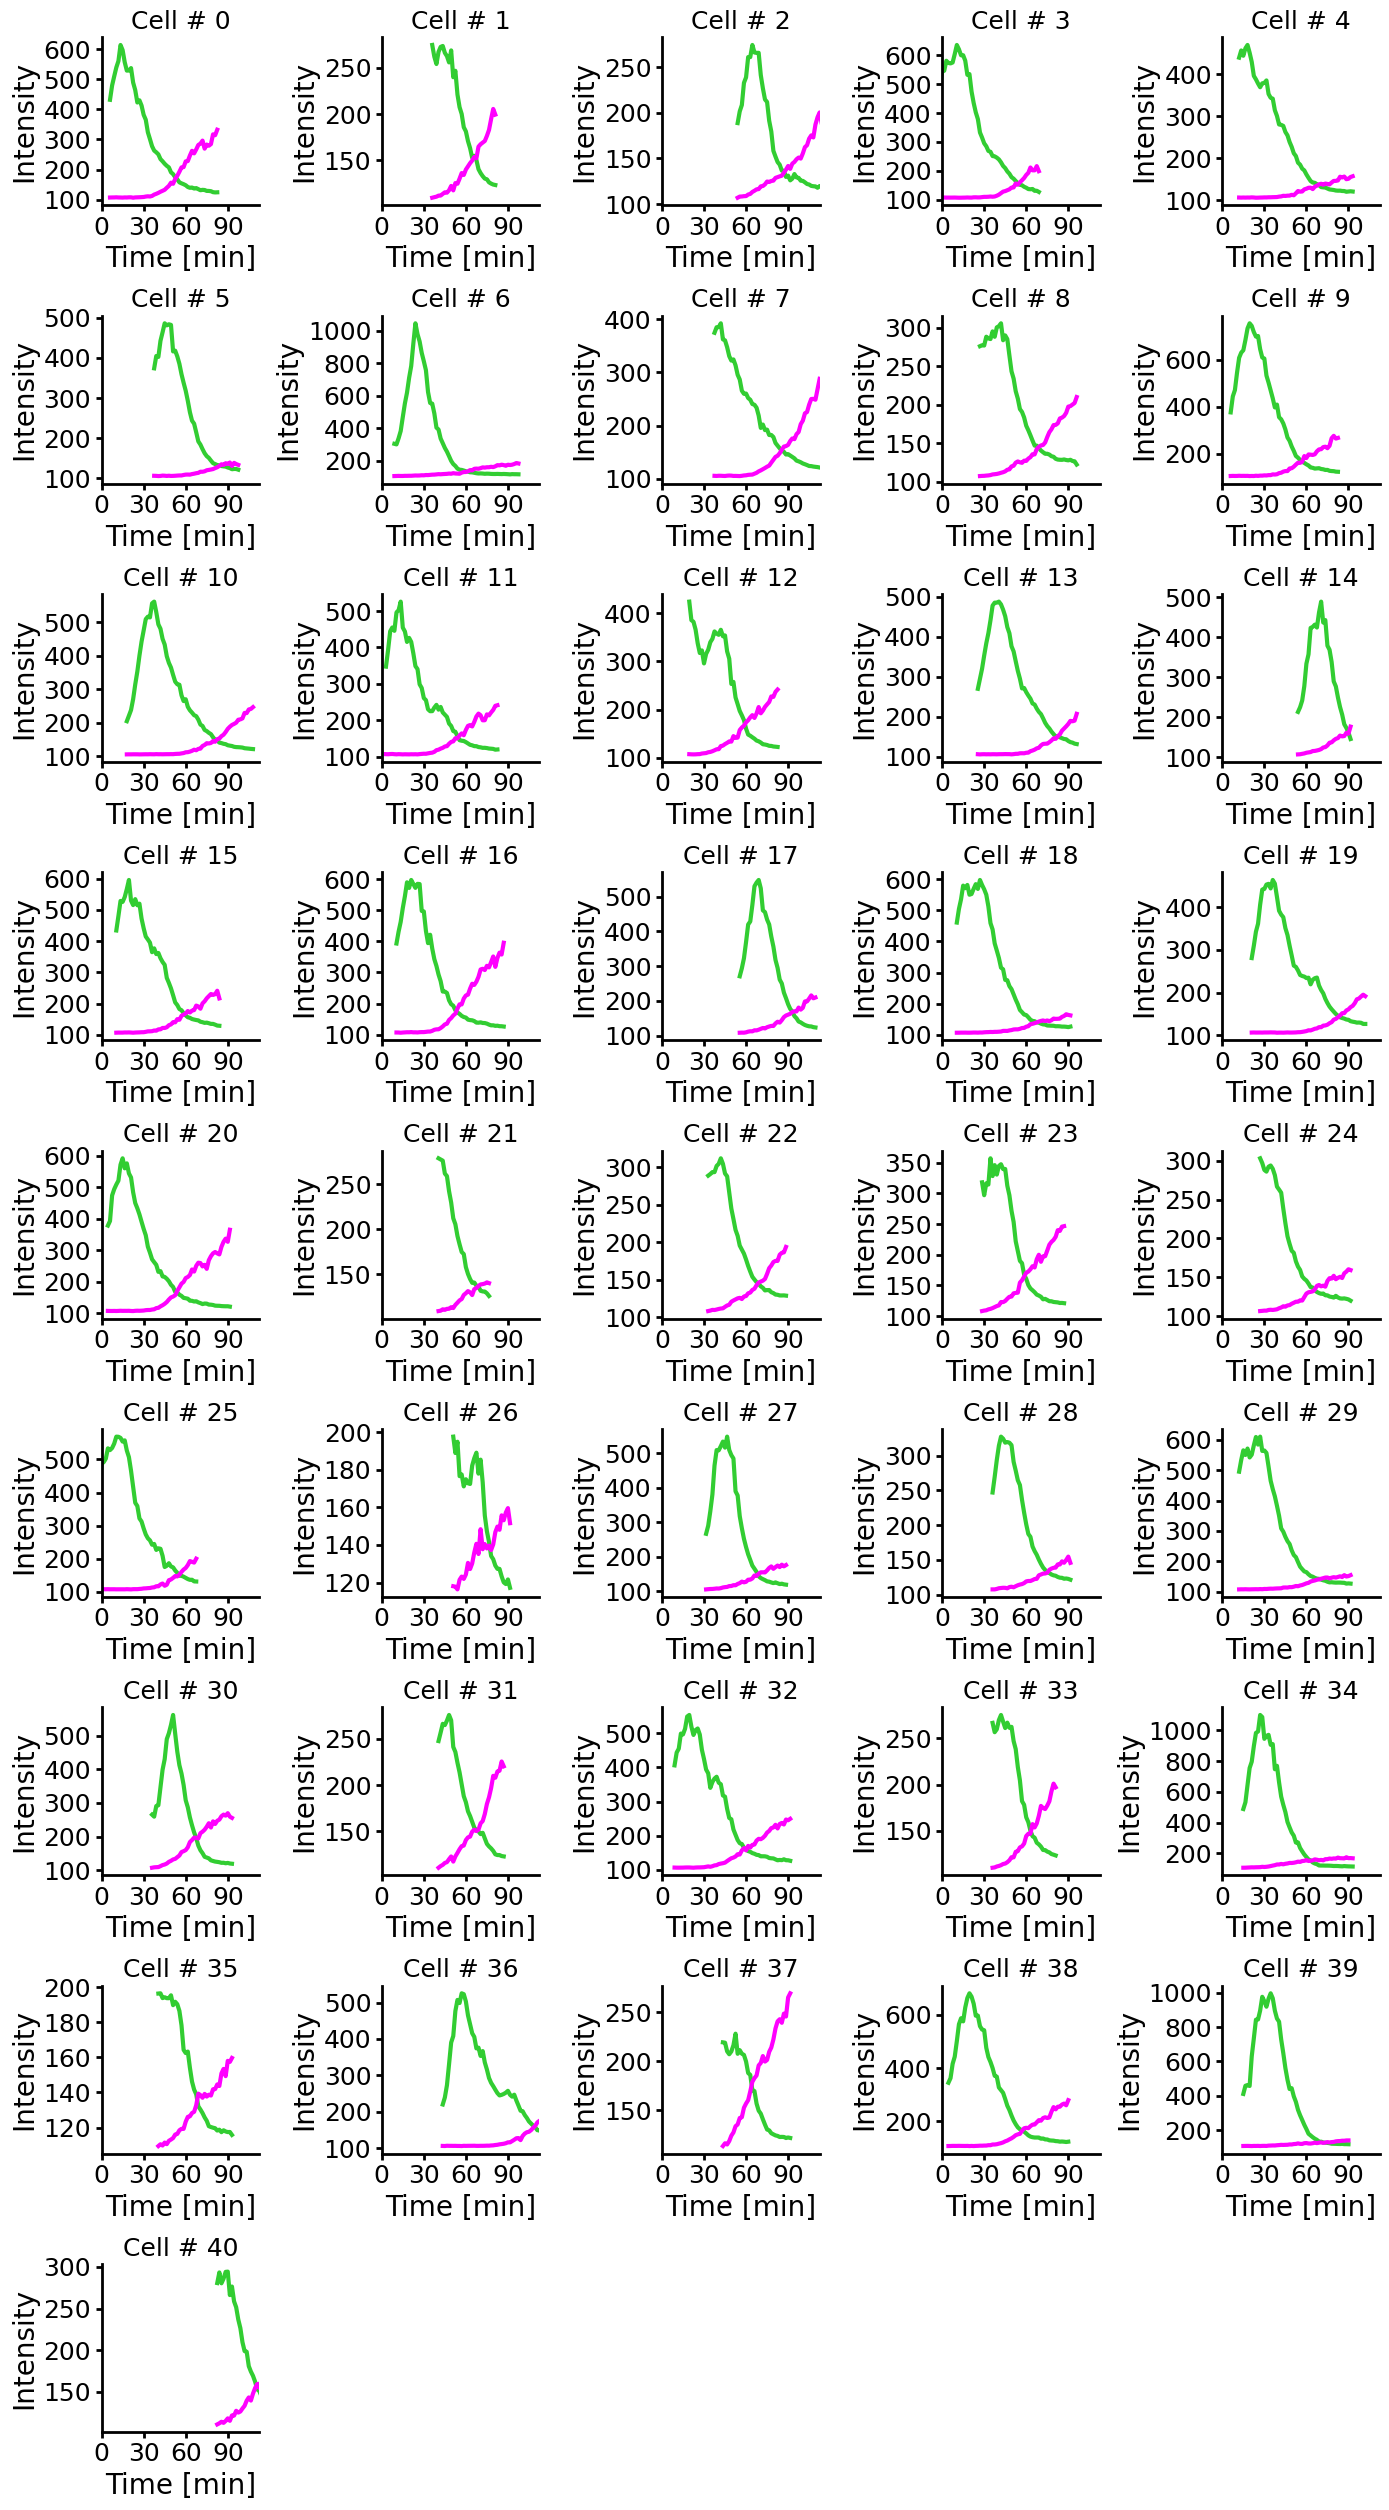

In [8]:
# Cells that do not divide
# Define the dimensions of the subplot
n_cols =  5
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

size_fig = n_rows*(14/n_cols)

# Initialize the figure size
fig= plt.figure(figsize=[14,size_fig])

for j in range(n_cells):
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    plt.plot(tracks_save_l[j], linewidth=3, color='limegreen')
    plt.plot(tracks_save_m[j], linewidth=3, color='magenta')

    plt.title('Cell # %d'%j, fontsize = 18)
    plt.xlabel('Time [min]', fontsize=20)
    locs, labels = plt.xticks()
    plt.xticks(np.arange(5,90,20), map(int,np.arange(0,85,20)*tr_min), fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Intensity', fontsize=20)
    plt.xlim([5,80])

    ax = plt.gca()
    ax.tick_params(width=2, length=4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(0)
    plt.tight_layout()
    
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/Her1-Mesp-invivo.pdf', format='pdf', bbox_inches='tight')

### Las peak of her 1 vs Mesp onset

The crosses indicate the peaks of her 1 and the dashed line indicated the onset of Mesp (as calculated in the notebook for Figure 1C). In green is the trace of Her1 and in blue the trace for Mesp. 

No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected


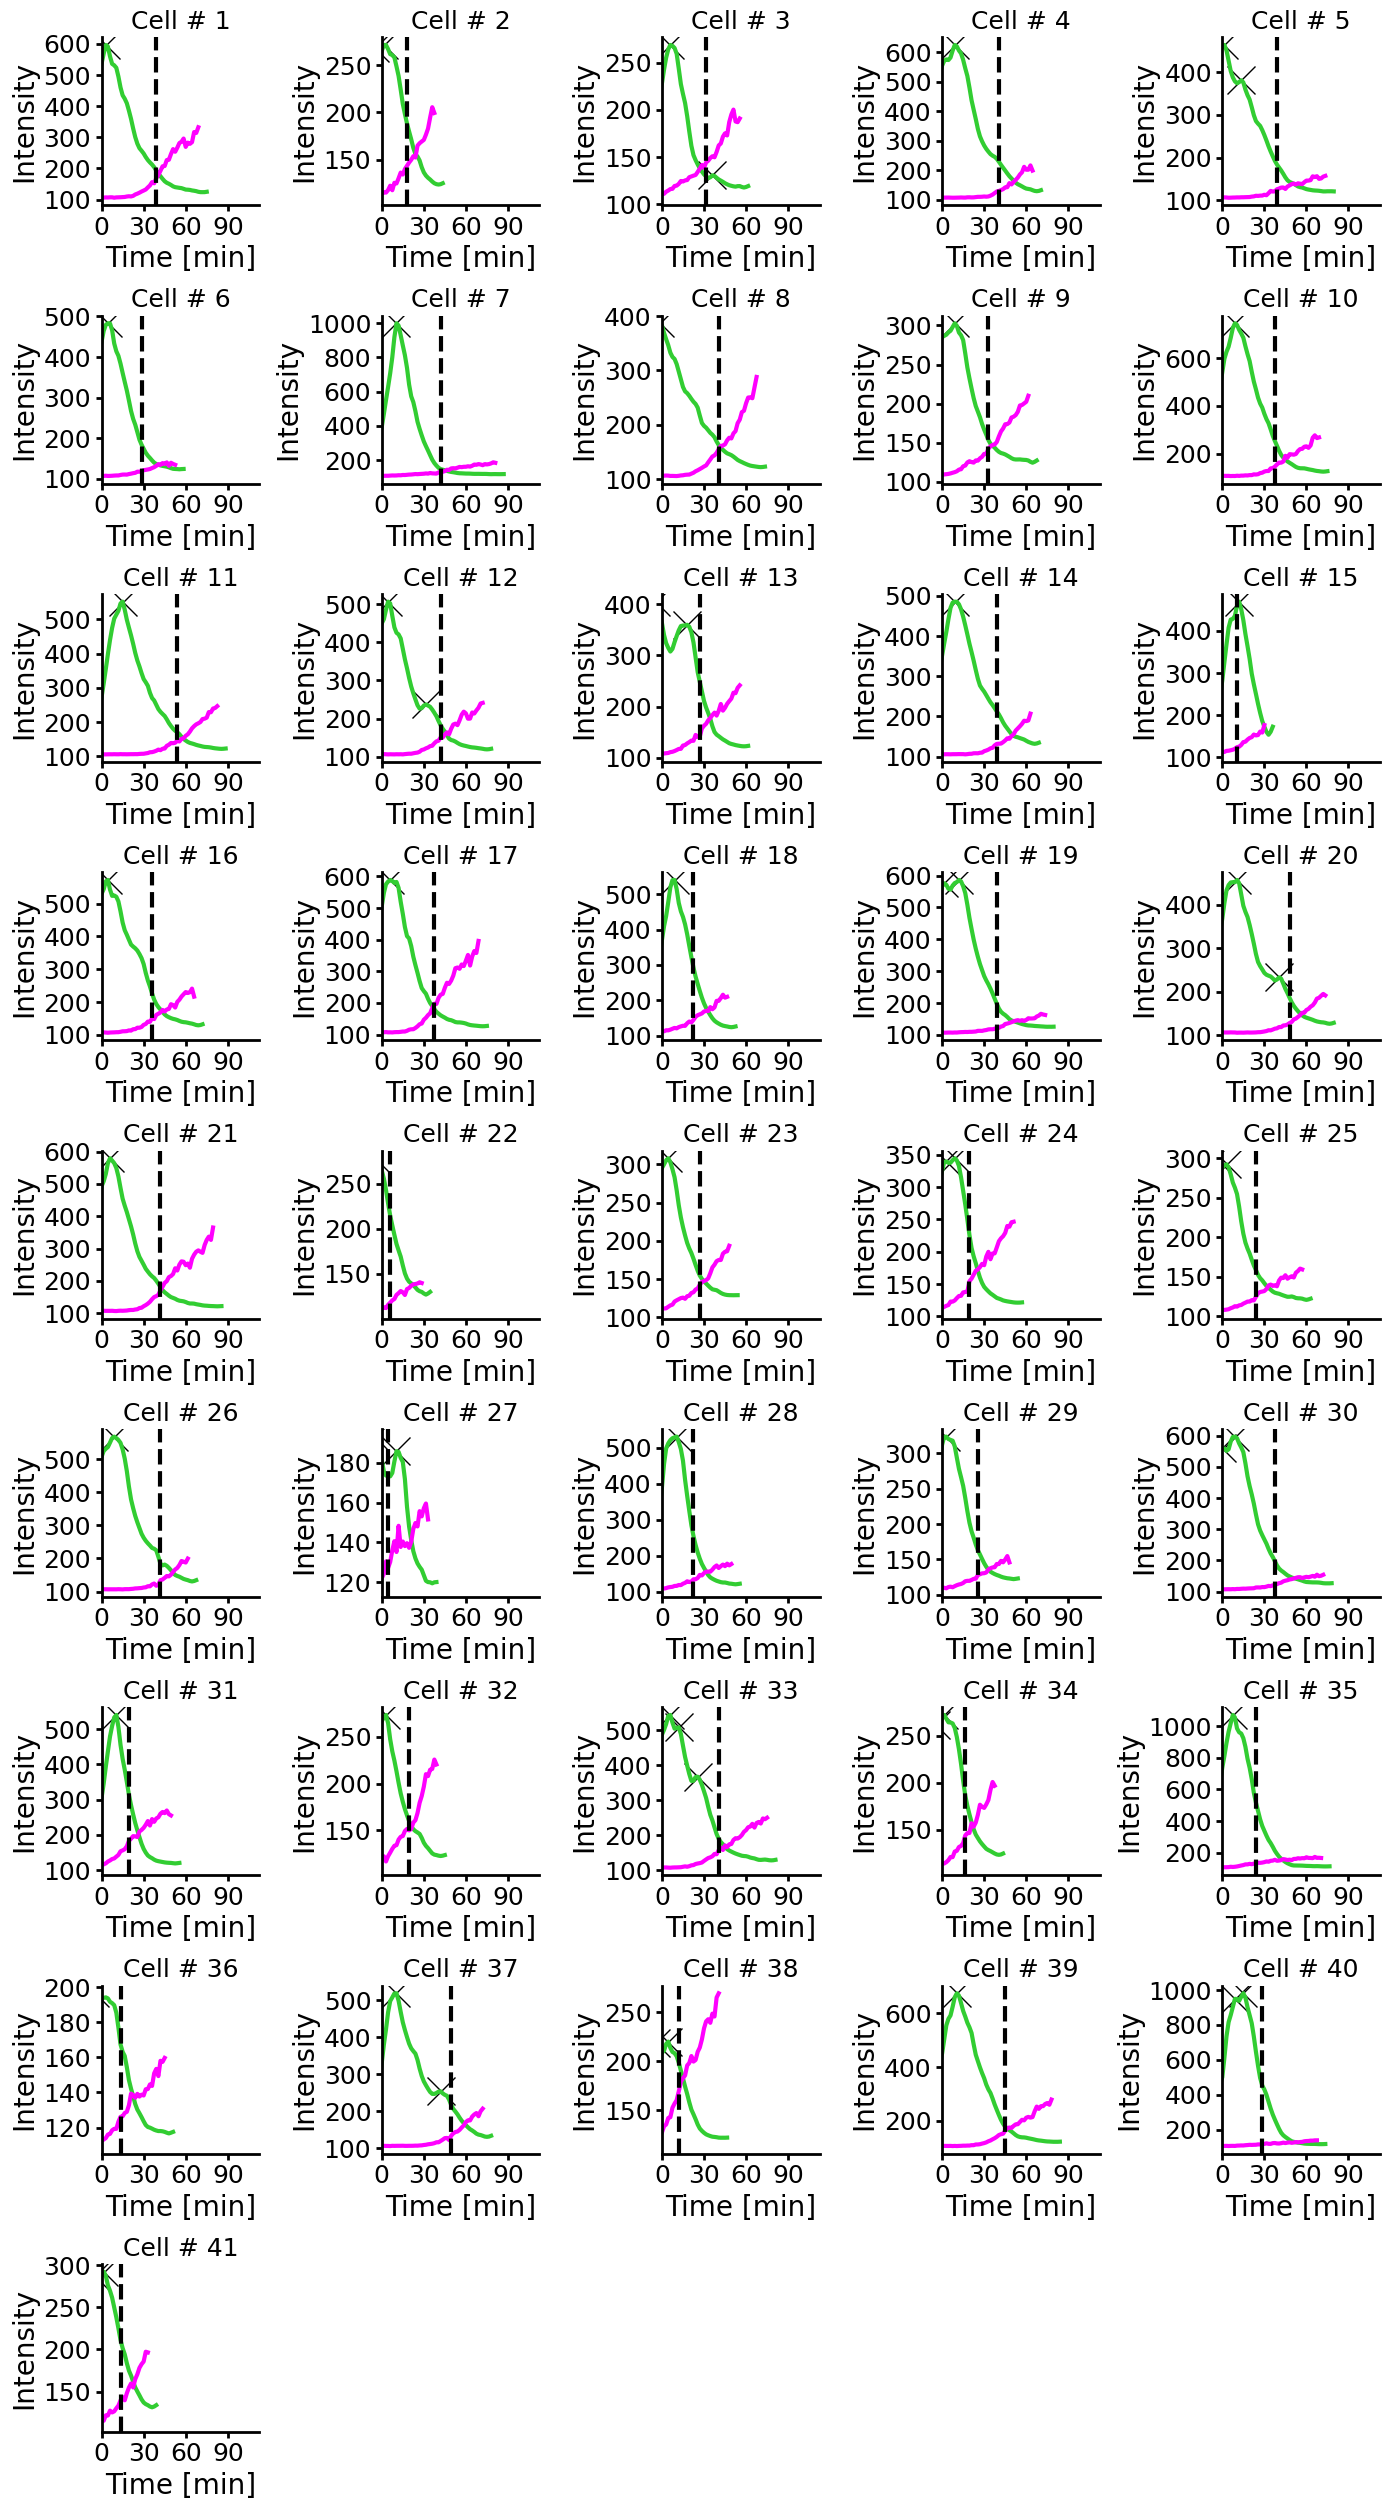

In [9]:
# Peak detection parameters

# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 1.5 # For maxima
prominence_val_ = 4 # For minima

# Width
width_val = 1 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'no_ts_as'

# Averaging window size
window = 9


# Define the dimensions of the subplot
n_cols =  5
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size

size_fig = n_rows*(14/n_cols)
fig = plt.figure(figsize=[14,size_fig])

# Save the Her 1 last peak
last_peak = []
# Save Mesp onset
onset_mesp = []

# Window size for lag correlation of mesp
window = 5
    

for j in range(n_cells):
    
    # HER 1 LAST PEAK
    track = tracks_save_l[j][~np.isnan(tracks_save_l[j])]
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(track, window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val, \
                           prominence_val_, width_val, width_val_, analysis)
    
    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(track, window)
    
    # Safe the last peak
    last_peak.append(peaks.peaks[-1])
    
    # MESP ONSET
    # Mesp traces for each cell
    intensities = tracks_save_m[j][~np.isnan(tracks_save_m[j])]
    X = np.zeros((len(intensities[window:]),2))
    X[:,0] = intensities[window:]
    X[:,1] = intensities[:-window]
    
    # K-means to cluster the lag (=window) correlation of Mesp 
    y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

    ind_cut = np.where(y_pred[window:]==y_pred[-1])[0]+window
    onset_mesp.append(ind_cut[0])
    
    plt.plot(peaks.peaks, y[peaks.peaks], "xk", markersize=20, linewidth=3);  
    plt.plot(y, color='limegreen', linewidth=3); 
    plt.plot(intensities, color='magenta', linewidth=3)
    plt.axvline(ind_cut[0], color='black', linewidth=3, linestyle='dashed')

    plt.title('Cell # %d'%(j+1), fontsize = 18)
    plt.xlabel('Time [min]', fontsize=20)
    locs, labels = plt.xticks()
    plt.xticks(np.arange(5,90,20), map(int,np.arange(0,85,20)*tr_min), fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Intensity', fontsize=20)
    plt.xlim([5,80])
    ax = plt.gca()
    ax.tick_params(width=2, length=4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/Her1-Mesp-invivo-Smoothed.pdf', format='pdf', bbox_inches='tight')

No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected


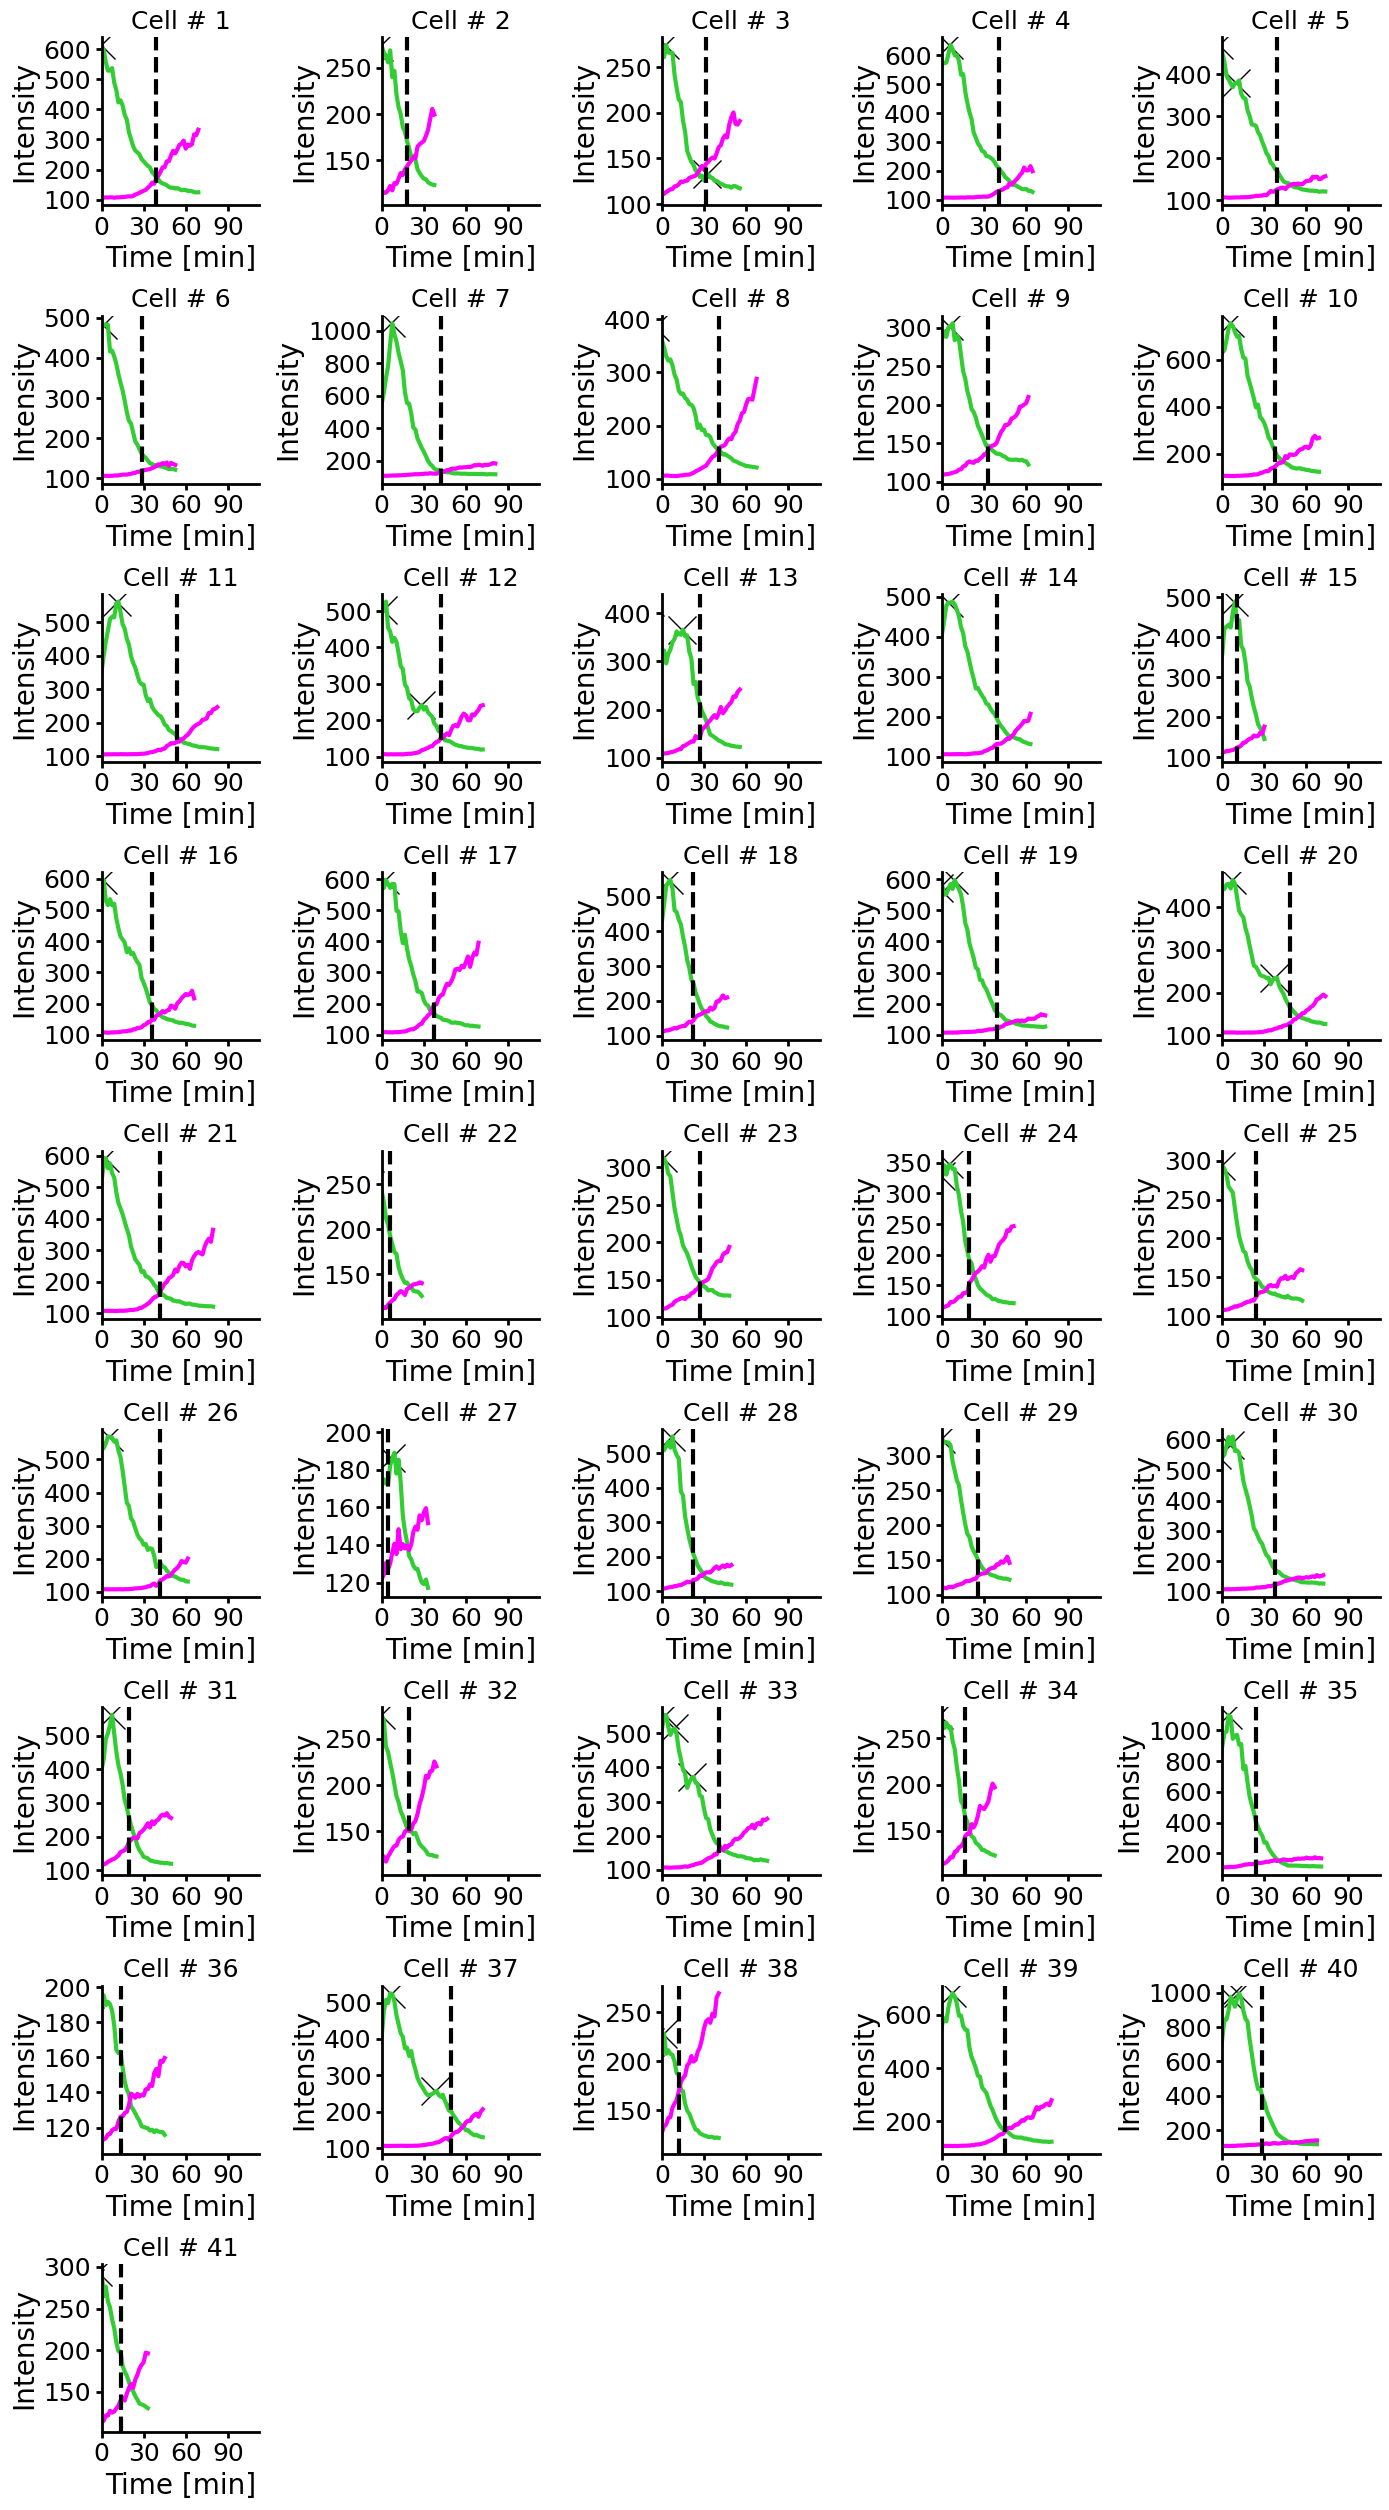

In [10]:
# Peak detection parameters

# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 1.5 # For maxima
prominence_val_ = 4 # For minima

# Width
width_val = 1 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'no_ts_as'

# Averaging window size
window = 9

# Define the dimensions of the subplot
n_cols =  5
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
size_fig = n_rows*(14/n_cols)
fig = plt.figure(figsize=[14,size_fig])

# Save the Her 1 last peak
last_peak = []
# Save Mesp onset
onset_mesp = []

# Window size for lag correlation of mesp
window = 5
    

for j in range(n_cells):
    
    # HER 1 LAST PEAK
    track = tracks_save_l[j][~np.isnan(tracks_save_l[j])]
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(track, window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val, \
                           prominence_val_, width_val, width_val_, analysis)
    
    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(track, window)
    
    # Safe the last peak
    last_peak.append(peaks.peaks[-1])
    
    # MESP ONSET
    # Mesp traces for each cell
    intensities = tracks_save_m[j][~np.isnan(tracks_save_m[j])]
    X = np.zeros((len(intensities[window:]),2))
    X[:,0] = intensities[window:]
    X[:,1] = intensities[:-window]
    
    # K-means to cluster the lag (=window) correlation of Mesp 
    y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

    ind_cut = np.where(y_pred[window:]==y_pred[-1])[0]+window
    onset_mesp.append(ind_cut[0])
    
    plt.plot(peaks.peaks-window/2, track[peaks.peaks-window//2], "xk", markersize=20, linewidth=3);  
    plt.plot(track, color='limegreen', linewidth=3); 
    plt.plot(intensities, color='magenta', linewidth=3)
    plt.axvline(ind_cut[0], color='black', linewidth=3, linestyle='dashed')

    plt.title('Cell # %d'%(j+1), fontsize = 18)
    plt.xlabel('Time [min]', fontsize=20)
    locs, labels = plt.xticks()
    plt.xticks(np.arange(5,90,20), map(int,np.arange(0,85,20)*tr_min), fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Intensity', fontsize=20)
    plt.xlim([5,80])
    ax = plt.gca()
    ax.tick_params(width=2, length=4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(0)
    

plt.tight_layout()
plt.show()
fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/Her1-Mesp-invivo-Raw.pdf', format='pdf', bbox_inches='tight')

#### Plot disrtribution of Mesp with respect the last peak of Her 1

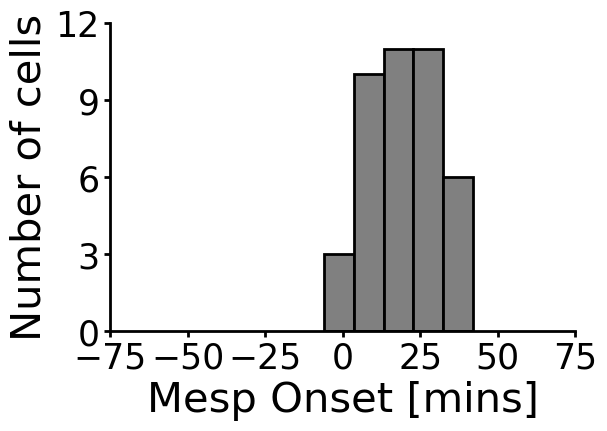

In [11]:
fig = plt.figure(figsize=[6,4])
# Mesp onset using Her 1 las peak as reference
onset_mesp_lp = np.array(onset_mesp)*tr_min-np.array(last_peak)*tr_min
#plt.axvline(0, color='darkblue', linewidth=4, linestyle='--', alpha=1)

plt.hist(onset_mesp_lp, color='grey', bins='fd', edgecolor='black', linewidth=2, align='mid');
plt.xlabel('Mesp Onset [mins]', fontsize=30)
plt.ylabel('Number of cells', fontsize=30)
plt.xlim([-50,50])
plt.xticks(np.arange(-75, 90, 25), fontsize=25)
plt.yticks(np.arange(0,14,3), fontsize=25);

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/MespOnset-invivo-HeidiLooping.pdf', format='pdf', bbox_inches='tight')

## Dynamics analysis on Looping PSM4 cells

<a id='Loop'></a>

If you want to go back to the top of the notebook: [TOP](#top)

For this, we import the data from 2 embryos where cells were tracked from the PSM4 area. Once the data is organized, we will measure the number of peaks, ratio of slowing down and the dynamics of Mesp onset vs Her 1 last peak. The .csv files were exported from Mastodon where we performed the tracking. 

In [12]:
# Position 1 and 2 correspond to two embryos from the same experiment
position = [1,2]

In [13]:
# Path to .xml file generated when creating the .hdf5
path_xml = ['../Data/Figure 2/Figure 2 - In vivo/Position1_20191213.xml', '../Data/Figure 2/Figure 2 - In vivo/Position2_20191213.xml']

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = ['../Data/Figure 2/Figure 2 - In vivo/Position1-20191213-PSMd', '../Data/Figure 2/Figure 2 - In vivo/Position2-20191213-PSMd']

# Path to roi zip
path_roi = ['../Data/Figure 2/Figure 2 - In vivo/RoiSet-Position1.zip', '../Data/Figure 2/Figure 2 - In vivo/RoiSet-Position2.zip']

### Image characteristics

In [14]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes


for i in range(len(position)):
    exec('fts%d = xml_features(path_xml[i])'%position[i])
    fts = xml_features(path_xml[i])
    
    # Features from the image obtained from the .xml generated by BigData Viewer
    print('Image features from POSITION # %d'%(i+1))
    print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
    print('There are %d frames in total.'%fts.n_frames)
    print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
    print('There are %d Z-slices in total'%fts.n_slices)
    print(' ')

Image features from POSITION # 1
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 
Image features from POSITION # 2
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 


### Organize the data

In [15]:
# Save tracks coming from all experiments

for i in range(len(position)):
    # Function to obtain all the spots' information from the .csv file
    spots = csv_features(path_csv[i], path_xml[i])
    
    # Order the time series according to each individual cell
    exec('tracks%d = ordering_tracks(path_csv[i], path_xml[i])'%position[i])
    

There are no Tags.
There are no Tags.


### Peak alignment

In [16]:
# Align using their temporal position

# First find the experiment with the maximum number of frames
# Then compute the number of total cells in all experiments

n_cells_pos = []
n_frames = 0

for i in range(len(position)):
    n_cells_pos.append(eval('tracks%d.n_tracks_divs'%position[i]))
    if eval('fts%d.n_frames'%position[i])>n_frames:
        n_frames = eval('fts%d.n_frames'%position[i])

n_cells = sum(n_cells_pos)    

# Save all the cells from all the experiments in the same array 
tracks_save = np.ones((n_cells, n_frames))*np.nan

# Save also the x,y positions
x_save = np.ones((n_cells, n_frames))*np.nan
y_save = np.ones((n_cells, n_frames))*np.nan
z_save = np.ones((n_cells, n_frames))*np.nan

count = 0

for k in range(len(position)):
    # Fill the timepoints where there are no cells tracked with nan
    tracks_aux = np.ones((n_cells_pos[k], n_frames))*np.nan

    # Save also the x,y positions
    x_aux = np.ones((n_cells_pos[k], n_frames))*np.nan
    y_aux = np.ones((n_cells_pos[k], n_frames))*np.nan
    z_aux = np.ones((n_cells_pos[k], n_frames))*np.nan

    # For each track 
    for i in range(n_cells_pos[k]):

        # Add the tracked spot to the specific time frame to which it corresponds
        for j,val in enumerate(eval('tracks%d.spots_features["Frames"][i]'%position[k])):
            tracks_aux[i,val] = eval('tracks%d.spots_features["Mean1"][i][j]'%position[k])
            x_aux[i,val] = eval('tracks%d.spots_features["X"][i][j]'%position[k])
            y_aux[i,val] = eval('tracks%d.spots_features["Y"][i][j]'%position[k])
            z_aux[i,val] = eval('tracks%d.spots_features["Z"][i][j]'%position[k])
            
    tracks_save[count:count+n_cells_pos[k],:] = tracks_aux
    x_save[count:count+n_cells_pos[k],:] = x_aux
    y_save[count:count+n_cells_pos[k],:] = y_aux
    z_save[count:count+n_cells_pos[k],:] = z_aux
    
    count += n_cells_pos[k]

### Waterfall plots

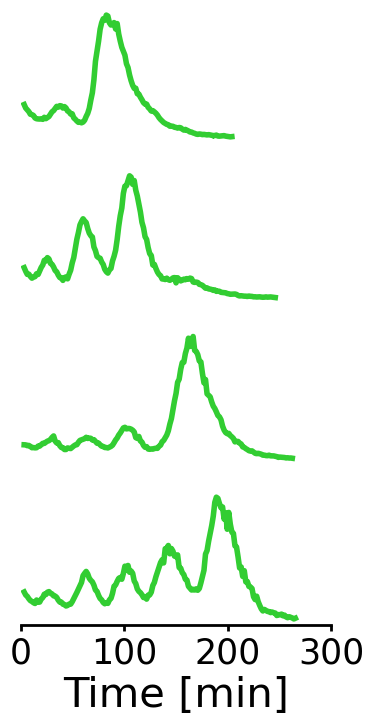

In [17]:
cells4 = [12,32,21,7]

fig = plt.figure(figsize=[4,8])

for i,val in enumerate(cells4):
    ax = plt.subplot(4,1,i+1)
    plt.plot(tracks_save[val], linewidth=4, color='limegreen')
    plt.xlim([0,200])
    if i==3:
        plt.xticks(np.arange(8,250,100/1.5), map(int,np.arange(0,250,100/1.5)*tr_min), fontsize=25)
        top_side = ax.spines["top"]
        top_side.set_visible(False)
        left_side = ax.spines["left"]
        left_side.set_visible(False)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.xaxis.set_tick_params(width=2, length=4)
        plt.yticks([])
        plt.xlabel('Time [min]', fontsize=30)
        
    else:
        plt.xticks([])
        plt.axis('off')
    
    plt.xlim([8,208])
    
fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/Looping-waterfall.pdf')

### Example cell for Looping

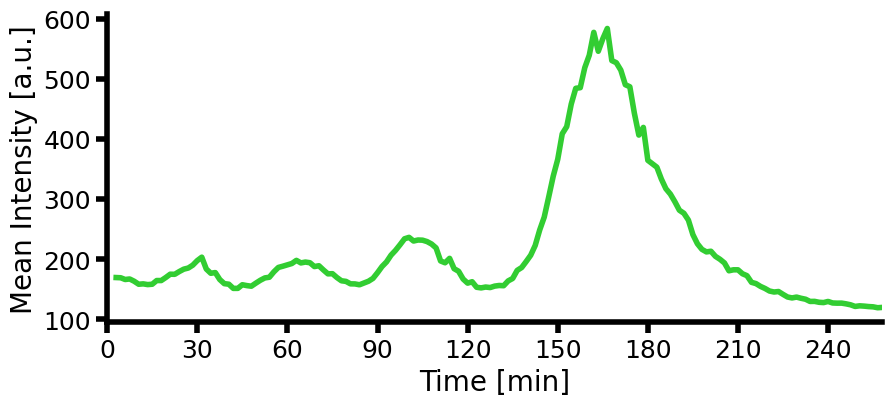

In [18]:
# Cell for figure 2A
plt.style.use('default')
fig = plt.figure(figsize=[10,4])
j = 21
plt.plot(tracks_save[j], linewidth=4, color='limegreen')

plt.xlabel('Time [min]', fontsize=20)
locs, labels = plt.xticks()
plt.xticks(np.arange(8,190,20), map(int,np.arange(0,182,20)*tr_min), fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Mean Intensity [a.u.]', fontsize=20)
plt.xlim([8,180])
ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.show()
fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/Her1-singlecell-invivo.pdf', format='pdf', bbox_inches='tight')

### Smoothing signal

Apply an averaging window to the data and plot each individual raw track (in black) and the smoothed signal (in dashed blue) to show the smoothing filter is not geting rid of any important part od the trace. 

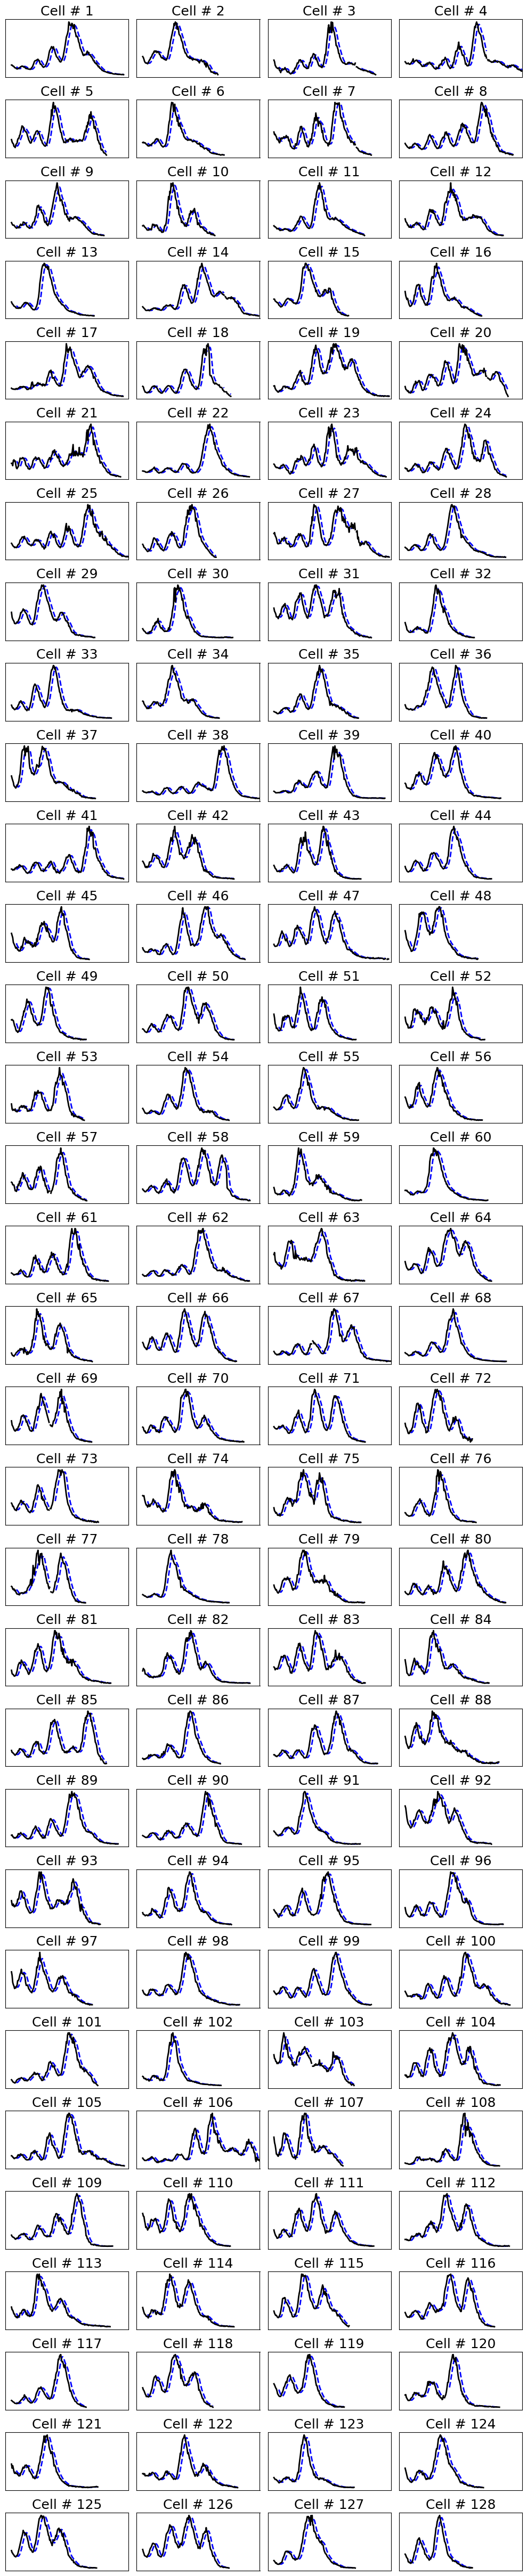

In [19]:
# Averaging window size
window = 9

# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,50])

for j in range(n_cells):
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    # Smoothing filter
    y = smoothing_filter(tracks_save[j], window)

    plt.plot(y, color='blue',linewidth=2, linestyle = 'dashed')
    plt.plot(tracks_save[j],linewidth=2, color='black')
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    locs, labels = plt.xticks()
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0,200])

plt.tight_layout()
plt.show()

### Peak deteciton 

In [20]:
# Peak detection parameters
ind = 0 #8 
# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 8.1 # For maxima
prominence_val_ = 2 # For minima

# Width
width_val = 2 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'no_ts_as'

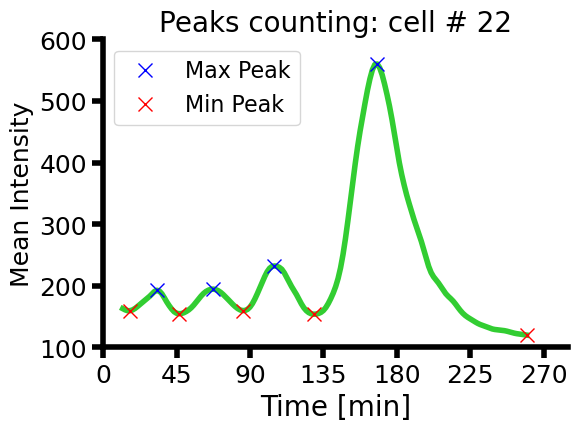

In [21]:
# Example cell

j = 21
fig = plt.figure(figsize=[6,4])
peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                       dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)

# If no peaks are detected, print the cell number
if peaks.count > 0 :
    print(j+1)

# Correct for the last peak in case it was not detected:
y = smoothing_filter(tracks_save[j][ind:], window)

# Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1

# Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
if np.isnan(y[peaks.peaks_][0]):
    peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1


plt.plot(y, color='limegreen', linewidth=4)
plt.plot(peaks.peaks, y[peaks.peaks], "x", color='blue', markersize=10, label='Max Peak'); plt.plot(peaks.peaks_, y[peaks.peaks_], "xr", markersize=10, label='Min Peak');
plt.legend(fontsize=16)
plt.title('Peaks counting: cell # %d'%(j+1), fontsize = 20)
plt.xlabel('Time [min]', fontsize=20)
plt.xticks(np.arange(10,210,30), map(int,np.arange(0,200,30)*tr_min), fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Mean Intensity', fontsize=18)
plt.xlim([10,200])
plt.ylim([100,600])

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.show()
#CH COMMENT, this one is not in results
fig.savefig('../Data/Figure 2/Figure 2 - In vivo/ExamplePeaksDetectionCell.pdf', format='pdf', bbox_inches='tight')

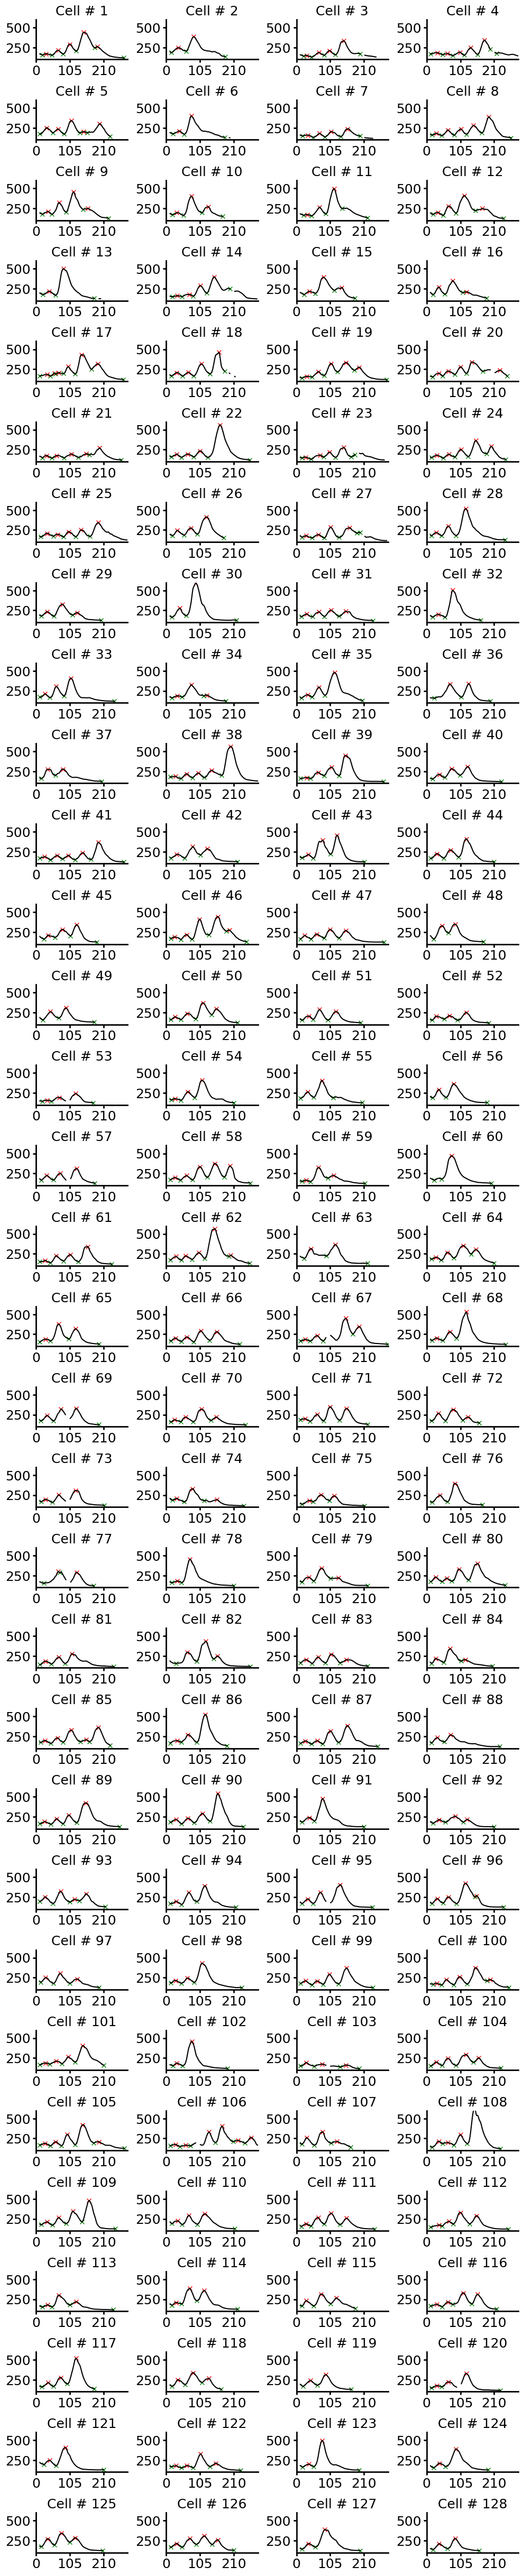

In [22]:
# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,50])

for j in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # If no peaks are detected, print the cell number
    if peaks.count > 0 :
        print(j+1)

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window)
    
    # Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
    peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1
    
    # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
    if np.isnan(y[peaks.peaks_][0]):
        peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1
    
    plt.plot(peaks.peaks, y[peaks.peaks], "xr"); plt.plot(peaks.peaks_, y[peaks.peaks_], "xg"); plt.plot(y, color='black'); #plt.legend(['Max Peak', 'Min Peak'])
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    plt.xticks(np.arange(10,210,70), map(int,np.arange(0,200,70)*tr_min), fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim([10,200])
    plt.ylim([100,600])
    ax = plt.gca()
    ax.tick_params(width=2, length=4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(0)
    

plt.tight_layout()
plt.show()

### How many cells have a mini-peak?

In [31]:
mini_peak = 0
no_mini_peak = 0
n_cells_total = 0
for j in range(n_cells):
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window) 
  
    if len(peaks.peaks)>1:
        n_cells_total += 1
        if y[peaks.peaks[-1]] > y[peaks.peaks[-2]]:
            no_mini_peak += 1
        elif y[peaks.peaks[-1]]<= y[peaks.peaks[-2]]:
            mini_peak += 1

In [32]:
print(f'There are {(mini_peak/n_cells_total)*100} cells ith mini-peaks')

There are 42.51968503937008 cells ith mini-peaks


### Calculate the period (difference between two maxima)

In order to obtain the period for each cycle we calculate the difference between two consecutive maximum peaks: 
$ \text{Max}(peak[t+1]) - \text{Max}(peak[t]) $

In [33]:
periods = []
amplitudes = []
n_peaks = []
last_peak_time = []

anterior_period = []
posterior_period = []
for j in range(n_cells):
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window) 
    
    # Calculate the period: difference between two maxima
    periods.append(np.diff(peaks.peaks))
    n_peaks.append(len(peaks.peaks))
    amplitudes.append(tracks_save[j][ind:][peaks.peaks])
    last_peak_time.append(peaks.peaks[-1]-window/2)
    if np.size(peaks.peaks)>1:
        anterior_period.append(np.diff(peaks.peaks)[-1]-window/2)
        posterior_period.append(np.diff(peaks.peaks)[0]-window/2)

In [34]:
# Remove ouliers from a list
def reject_outliers(data, m=3):
    return data[abs(data - np.nanmean(data)) < m * np.nanstd(data)]

# Find differences between two lists
def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

In [35]:
periods_all = reject_outliers(np.array([item for sublist in periods for item in sublist]))

In [36]:
print('The average period is: %.2f'%(np.mean(periods_all)*tr_min))
print('The SD period is: %.2f'%(np.std(periods_all)*tr_min))

The average period is: 42.92
The SD period is: 6.78


Mean Posterior Period = 33.53
Standard deviation Posterior Period = 6.99 

Mean Anterior Period = 41.59
Standard deviation Anterior Period = 7.72


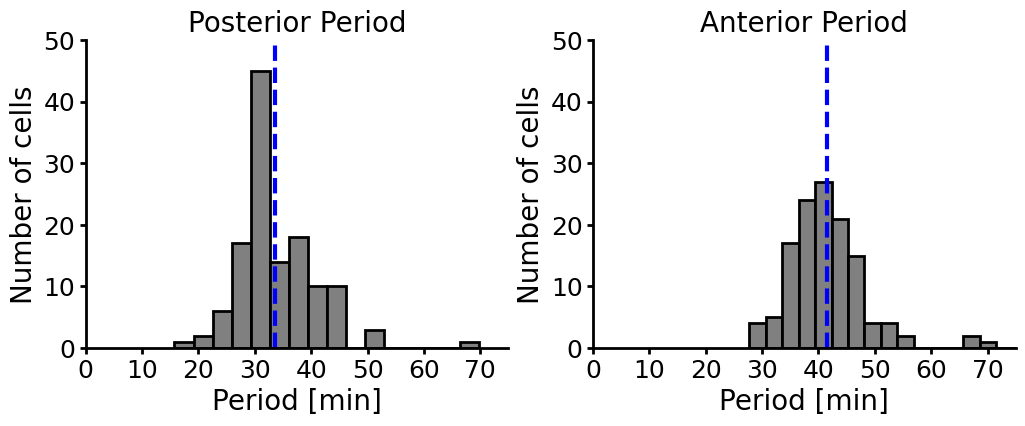

In [42]:
fig = plt.figure(figsize=[12,4])

        
print('Mean Posterior Period = %.2f'%(np.mean(posterior_period)*tr_min))
print('Standard deviation Posterior Period = %.2f'%(np.std(posterior_period)*tr_min), '\n')
print('Mean Anterior Period = %.2f'%(np.mean(anterior_period)*tr_min))
print('Standard deviation Anterior Period = %.2f'%(np.std(anterior_period)*tr_min))

# Plot the periods
plt.subplot(121)
plt.hist(np.array(posterior_period)*tr_min, bins='fd', edgecolor='black', linewidth=2, color='gray');
plt.axvline(np.mean(posterior_period)*tr_min, linewidth=3, color='blue', linestyle='--')
plt.xlabel('Period [min]', fontsize=20)
plt.ylabel('Number of cells', fontsize=20)
plt.ylim([0,50])
plt.xlim([0,75])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.title('Posterior Period', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.subplot(122)
plt.hist(np.array(anterior_period)*tr_min, bins='fd', edgecolor='black', linewidth=2, color='gray');
plt.axvline(np.mean(anterior_period)*tr_min, linewidth=3, color='blue', linestyle='--')
plt.xlabel('Period [min]', fontsize=20)
plt.ylabel('Number of cells', fontsize=20)
plt.ylim([0,50])
plt.xlim([0,75])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.title('Anterior Period', fontsize=20);
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.show()
#CH COMMENT, does this belong here?
fig.savefig('../Data/Figure S2/Figure S2 - In vivo/Results/PeriodsAnteriorVsPosterior.pdf', format='pdf', bbox_inches='tight')

### Last Her1 Peak Times

Mean Last peak time = 146.92
Standard deviation Last peak time = 36.85


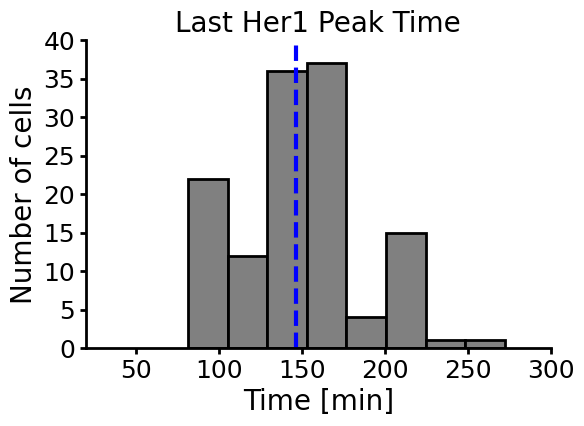

In [43]:
# Last peak Time

print('Mean Last peak time = %.2f'%(np.mean(last_peak_time)*tr_min))
print('Standard deviation Last peak time = %.2f'%(np.std(last_peak_time)*tr_min))

fig = plt.figure(figsize=[6,4])
plt.hist(np.array(last_peak_time)*tr_min, bins=8, edgecolor='black', linewidth=2, color='gray');
plt.axvline(np.mean(last_peak_time)*tr_min, linewidth=3, color='blue', linestyle='--')
plt.xlabel('Time [min]', fontsize=20)
plt.ylabel('Number of cells', fontsize=20)
plt.ylim([0,40])
plt.xlim([20,300])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.title('Last Her1 Peak Time', fontsize=20);
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
#CH COMMENT, does this belong here?
fig.savefig('../Data/Figure S2/Figure S2 - In vivo/Results/Her1LastPeakTime.pdf', format='pdf', bbox_inches='tight')

### Calculate successive peak ratio 
$Ratio = \frac{Period[t+1]}{Period[t]}$

In [44]:
# Remove ouliers from a list
def reject_outliers(data, m=3):
    return data[abs(data - np.nanmean(data)) < m * np.nanstd(data)]

# Find differences between two lists
def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

In [45]:
ratios = []
for i in range(len(periods)):
    
    # If there are at least 2 cycles
    if len(periods[i])>1:
        
        aux = []
        
        # For each period, calculate the ratio
        for j in range(1,len(periods[i])):
            aux.append(periods[i][j]/periods[i][j-1])
        
        ratios += aux

In [46]:
# Remove ouliers from a list
def reject_outliers(data, m=3):
    return data[abs(data - np.nanmean(data)) < m * np.nanstd(data)]

# Find differences between two lists
def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

# Remove outliers from the ratio array
ratios_final = reject_outliers(np.array(ratios))

# Outliers
ratio_outliers = Diff(ratios_final, np.array(ratios))

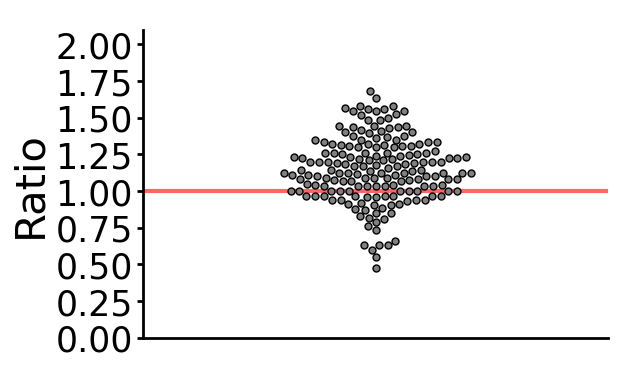

Mean: 1.14611
Standard Deviation: 0.224833


In [47]:
plt.style.use('default')
fig1 = plt.figure(figsize=[6,4])
sns.swarmplot(data=np.array(ratios_final),orient='v', color='gray',  size=5, edgecolor='black', linewidth=1)
plt.axhline(1, linewidth=3, color='red', alpha=0.6)
plt.xticks([])
plt.yticks(fontsize=25)
plt.ylabel('Ratio', fontsize=30)

plt.ylim([0,2.1])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.title(' ')
plt.show()

plt.show()

if len(position)>1:
    fig1.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/PerdioRatio-invivo-PosAll.pdf', format='pdf', bbox_inches='tight')
else:
    fig1.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/PerdioRatio-invivo-Pos%d.pdf'%position, format='pdf', bbox_inches='tight')
    
print('Mean: %g'%np.mean(ratios_final))
print('Standard Deviation: %g'%np.std(ratios_final))


### Number of peaks


In [48]:
aux = []
n_cycles_unique = np.unique(n_peaks)
for i in range(8):
    ind = i+1
    if any(ind == n_cycles_unique):
        ind_where = np.where(ind == np.array(n_peaks))[0]
        aux.append(len(ind_where))
    else:
        aux.append(0)
    
percent_cells = pd.Series(np.array(aux))

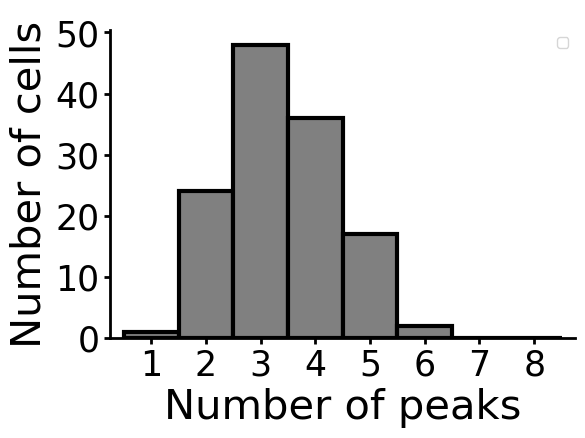

Mean: 3.39062
Standard Deviation: 1.0096


In [49]:
Fig = plt.figure(figsize=[6,4])

percent_cells.plot.bar(rot=0, subplots=True, color='gray', edgecolor='black', 
                           linewidth=3, width=1)
plt.xticks([0,1,2,3,4,5,6,7],[1,2,3,4,5,6,7,8], fontsize=25)
plt.yticks(fontsize=25)
plt.legend([])
plt.xlabel('Number of peaks', fontsize=30)
plt.ylabel('Number of cells', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.title(' ')
plt.show()


#Fig = plt.gcf()
#plt.show()
#plt.draw()


Fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/PeakHistogram-invivo-PosAll.pdf', format='pdf', bbox_inches='tight')

print('Mean: %g'%np.mean(n_peaks))
print('Standard Deviation: %g'%np.std(n_peaks))

### Successive Peak Ratio vs Successive Amplitude Ratio

In [50]:
ratio_func = lambda x: [x[i+1]/x[i] for i in range(len(x)-1)]

period_s = []
amplitudes_s = []

for i in range(n_cells):
    period_s.append(ratio_func(periods[i]))
    amplitudes_s.append(ratio_func(amplitudes[i][:-1]))

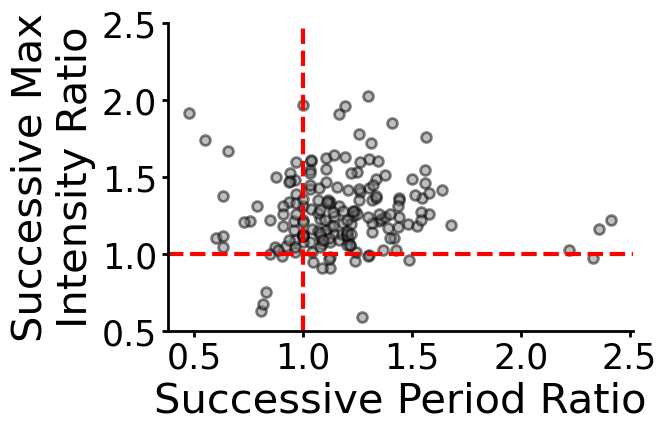

In [51]:
fig = plt.figure(figsize=[6,4])
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='gray', s=50, linewidth=2, edgecolor='black', alpha=0.5)
        
plt.axvline(1, linewidth=3, linestyle='dashed', color='red')
plt.axhline(1, linewidth=3, linestyle='dashed', color='red')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=25)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=25)

plt.xlabel('Successive Period Ratio', fontsize=30)
plt.ylabel('Successive Max\nIntensity Ratio', fontsize=30)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/SuccessivePeriod-Amplitude.pdf', format='pdf', bbox_inches='tight')


In [52]:
ratio1 = 0
n_cycles = 0
for i in range(n_cells):
    for j in range(len(amplitudes_s[i])):
        n_cycles +=1
        if amplitudes_s[i][j]>=1 and period_s[i][j]>=1:
            ratio1 += 1
            
        
print('There are %d cycles that slow down from %d total.'%(ratio1, n_cycles))
print('The proportion is: %d '%((ratio1/n_cycles)*100))

There are 130 cycles that slow down from 179 total.
The proportion is: 72 


### Successive Peak and Period ratio - KDE

In [53]:
x = []
y = []

xy_min = 0.5
xy_max = 2
step = 0.5

# create data
for i in range(n_cells):

    x += period_s[i]
    y += amplitudes_s[i]

# Convert into array
x = np.array(x)
y = np.array(y)
        
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 300
k = kde.gaussian_kde([x,y])
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
xi, yi = np.mgrid[xy_min:xy_max:nbins*1j, xy_min:xy_max:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

/var/folders/j6/1vns_r4n3q3c74_knnjh859c0000gq/T/ipykernel_12971/1742679133.py:20: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y])


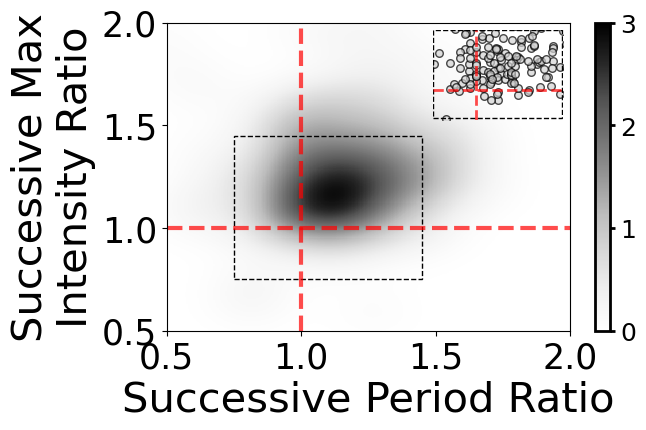

In [54]:
fig = plt.figure(figsize=[6.5, 4])
ax = fig.add_subplot(111)
# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location

mesh = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), 
               shading='auto', cmap='Greys', vmin=0, vmax=3)

axins = inset_axes(ax, width=1.3, height=0.9)

for i in range(n_cells):
    axins.scatter(period_s[i], amplitudes_s[i], color='lightgrey', s=30, linewidth=1, edgecolor='black', alpha=0.7)
    count += 1
        
axins.axis('off')
axins.set_xlim([0.75, 1.5])
axins.set_ylim([0.75, 1.5])
        
# Colorbar
cb = plt.colorbar(mesh, ax=ax)
cb.outline.set_linewidth(2)
cb.set_ticks(np.arange(0,4,1))
cb.set_ticklabels(np.arange(0,4,1), fontsize=18)
cb.ax.tick_params(width=2)

x_rect = 0.75
y_rect = 0.75
width = 0.70
height = 0.70
ax.add_patch(plt.Rectangle((x_rect, y_rect), width, height,
                           ls="--", ec="k", fc="none"))

x_rect = 0.75
y_rect = 0.76
width = 0.745
height = 0.74
axins.add_patch(plt.Rectangle((x_rect, y_rect), width, height,
                           ls="--", ec="k", fc="none"))

# Axes
ax.axvline(1, linewidth=3, linestyle='dashed', color='red', alpha=0.7)
ax.axhline(1, linewidth=3, linestyle='dashed', color='red', alpha=0.7)

axins.axvline(1, linewidth=2, linestyle='dashed', color='red', alpha=0.7)
axins.axhline(1, linewidth=2, linestyle='dashed', color='red', alpha=0.7)

ax.set(xlim=(xy_min,xy_max), ylim=(xy_min,xy_max))
ax.set_xticks(np.arange(xy_min,xy_max+step, step))
ax.set_yticks(np.arange(xy_min,xy_max+step, step))
ax.set_xticklabels(np.arange(xy_min,xy_max+step, step), fontsize=25)
ax.set_yticklabels(np.arange(xy_min,xy_max+step, step), fontsize=25)

ax.set_xlabel('Successive Period Ratio', fontsize=30)
ax.set_ylabel('Successive Max\nIntensity Ratio', fontsize=30)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()



fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/SuccessivePeriod-Amplitude-KDE_invivo.pdf', format='pdf', bbox_inches='tight')

### Calculate the average period of Her 1 

Interpeak interval of the first 2 peaks of the cells. We already calculated the periods of all the cycles as the difference of two maxima. As for the anterior period, we take the last period, and for the posterior period, the first one as long as there is more than one cycle. Here we exclude cells with 1 cycle only. 

Mean Posterior Period = 40.28
Standard deviation Posterior Period = 6.99 

Mean Anterior Period = 48.34
Standard deviation Anterior Period = 7.72


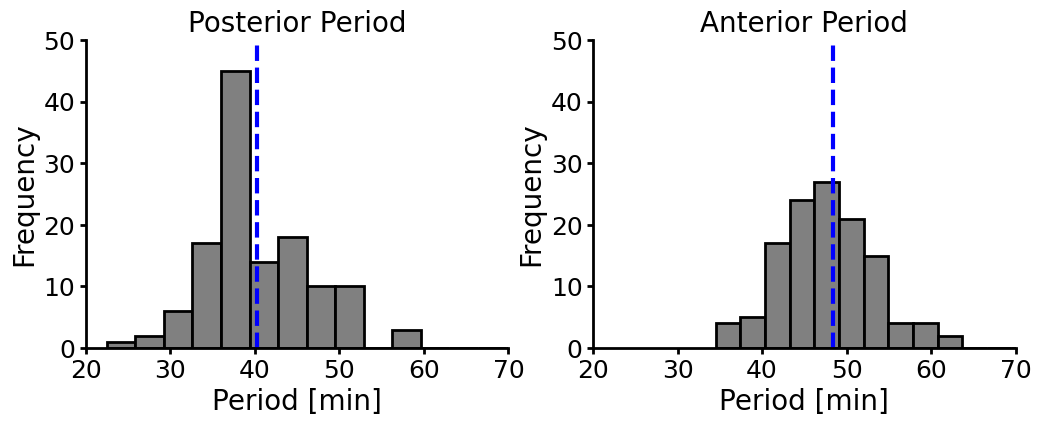

In [55]:
fig = plt.figure(figsize=[12,4])

posterior_period = []
for i in range(len(periods)):
    if np.size(periods[i]) > 0:
        posterior_period.append(periods[i][0]*tr_min)

anterior_period = []
for i in range(len(periods)):
    if np.size(periods[i]) > 0:
        anterior_period.append(periods[i][-1]*tr_min)
        
print('Mean Posterior Period = %.2f'%np.mean(posterior_period))
print('Standard deviation Posterior Period = %.2f'%np.std(posterior_period), '\n')
print('Mean Anterior Period = %.2f'%np.mean(anterior_period))
print('Standard deviation Anterior Period = %.2f'%np.std(anterior_period))

# Plot the periods
plt.subplot(121)
plt.hist(posterior_period, bins='fd', edgecolor='black', linewidth=2, color='gray');
plt.axvline(np.mean(posterior_period), linewidth=3, color='blue', linestyle='--')
plt.xlabel('Period [min]', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.ylim([0,50])
plt.xlim([20,70])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.title('Posterior Period', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.subplot(122)
plt.hist(anterior_period, bins='fd', edgecolor='black', linewidth=2, color='gray');
plt.axvline(np.mean(anterior_period), linewidth=3, color='blue', linestyle='--')
plt.xlabel('Period [min]', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.ylim([0,50])
plt.xlim([20,70])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.title('Anterior Period', fontsize=20);
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/PeriodsAnteriorVsPosterior.pdf', format='pdf', bbox_inches='tight')

### Her 1 Last peak time vs Mesp onset time

For this analysis we backtracked cells from an entire somite in a Looping transgenic embryo. These cells were followed for around 100 minutes in order to capture the last peak times. 

In [56]:
# Path to .xml file generated when creating the .hdf5
path_xml = '../Data/Figure 2/Figure 2 - In vivo/Position2_20191213.xml'

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = '../Data/Figure 2/Figure 2 - In vivo/Position2-somite'

In [57]:
# Function to obtain all the spots' information from the .csv file
spots = csv_features(path_csv, path_xml)

# Order the time series according to each individual cell
tracks = ordering_tracks(path_csv, path_xml)

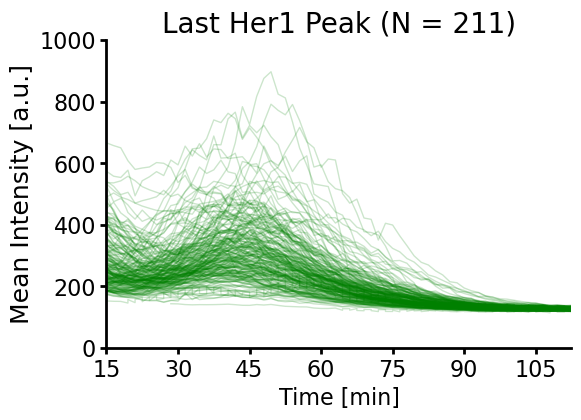

In [58]:
fig = plt.figure(figsize=[6,4])


# Cells that do not divide

for j in range(tracks.n_tracks_divs):
    plt.plot(tracks.spots_features['Frames'][j], tracks.spots_features['Mean1'][j], linewidth=1, color='green', alpha=0.2)


plt.title('Last Her1 Peak (N = %d)'%tracks.n_tracks_divs, fontsize = 20)
plt.xlabel('Time [min]', fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Mean Intensity [a.u.]', fontsize=18)
plt.xlim([10,75])
plt.ylim([0,1000])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/LastHer1Peak-Traces.pdf', format='pdf', bbox_inches='tight')

#### Obtain the last peak using the same method for peak detection as before

No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected
No peaks detected


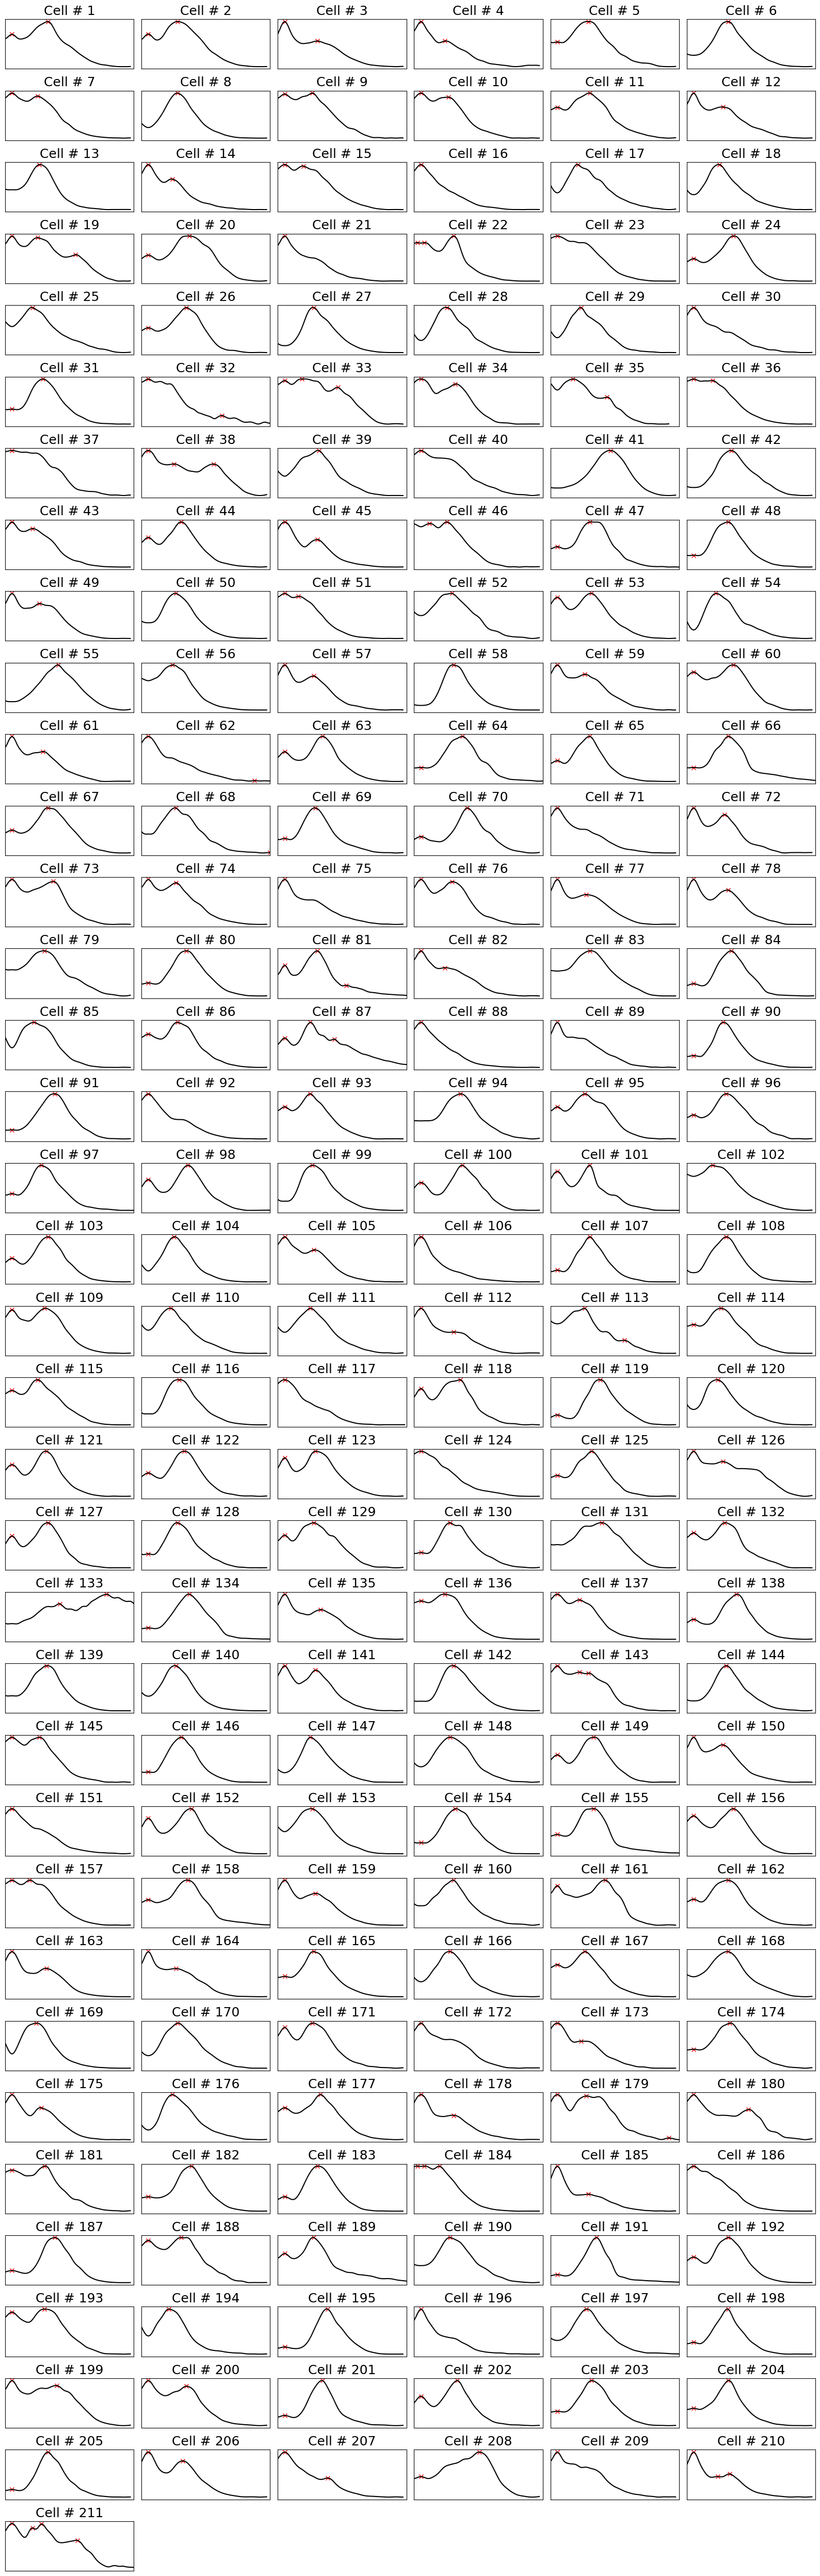

In [59]:
# Peak detection parameters

# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 1.5 # For maxima
prominence_val_ = 4 # For minima

# Width
width_val = 1 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'no_ts_as'

# Number of cells
n_cells = tracks.n_tracks_divs

# Define the dimensions of the subplot
n_cols =  6
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[16,50])

# Save the last peak
last_peak_s1 = []

for j in range(n_cells):
    
    track = tracks.spots_features['Mean1'][j]
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(track, window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(track, window)
    
    # Safe the last peak (+ window/2 because with the smoothing we missaligned the trace)
    last_peak = peaks.peaks[-1]+window/2
    
    # Last Peak time with respect S1 (the last time point for each track)
    last_frame = tracks.spots_features['Frames'][j][-1] # Last frame from this track
    last_peak_s1.append((last_frame-last_peak)*tr_min)
    
    plt.plot(peaks.peaks, y[peaks.peaks], "xr");  plt.plot(y, color='black'); 
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0,75])

plt.tight_layout()
plt.show()

Mesp mean onset: 42


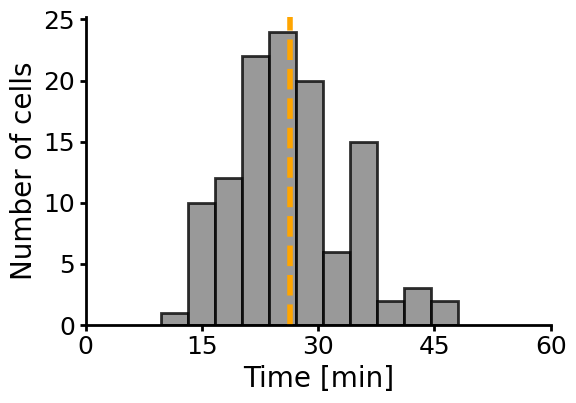

In [61]:
# Upload the mesp onset
onset_mesp_s1 = np.load('../Data/Figure 2/Figure 2 - In vivo/onset_mesp_on_s1.npy')

fig = plt.figure(figsize=[6,4])
plt.hist(onset_mesp_s1, bins='fd', linewidth=2, edgecolor='black', color='grey', alpha=0.8, density=False);

# Mean values plotted as dashed lines
plt.axvline(np.mean(onset_mesp_s1), color='orange', linewidth=4, linestyle='--', alpha=1)

print('Mesp mean onset: %d'%(np.mean(onset_mesp_s1)))


plt.xlabel('Time [min]',fontsize=20)
plt.ylabel('Number of cells',fontsize=20)
plt.xticks(np.arange(25,95,10), list(map(int, np.arange(0,70,10)*tr_min)), fontsize=18)
locs, labels = plt.yticks()
plt.yticks(fontsize=18)


plt.xlim([25,65])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.show()
fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/MesoOnset.pdf', format='pdf')

## Analysis of Mesp Data 

<a id='Mesp'></a>

If you want to go to the top of the notebook: [TOP](#top)

Import *in vivo* data from tracked cells going from Somite -I, 0, I. Cell tracks were obtained using Mastodon (from Fiji) and all the cells tracked belong to the same somite. 

In [62]:
# Position 1 and 2 correspond to two embryos from the same experiment
position = [1, 2]

In [63]:
# Path to .xml file generated when creating the .hdf5
path_xml = ['../Data/Figure 2/Figure 2 - In vivo/Mesp Data/Position1_20191031.xml', '../Data/Figure 2/Figure 2 - In vivo/Mesp Data/Position2_20191031.xml' ]  # Path to .xml file

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = ['../Data/Figure 2/Figure 2 - In vivo/Mesp Data/Position1', '../Data/Figure 2/Figure 2 - In vivo/Mesp Data/Position2']

# Path to zip were all the ROIs from the somites are
path_roi = ['../Data/Figure 2/Figure 2 - In vivo/Mesp Data/RoiSet-Position1.zip', '../Data/Figure 2/Figure 2 - In vivo/Mesp Data/RoiSet-Position2.zip']

### Image characteristics

In [64]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes


for i in range(len(position)):
    exec('fts%d = xml_features(path_xml[i])'%position[i])
    fts = xml_features(path_xml[i])
    
    # Features from the image obtained from the .xml generated by BigData Viewer
    print('Image features from POSITION # %d'%(i+1))
    print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
    print('There are %d frames in total.'%fts.n_frames)
    print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
    print('There are %d Z-slices in total'%fts.n_slices)
    print(' ')

Image features from POSITION # 1
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 239 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 
Image features from POSITION # 2
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 239 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 


### Organize the data

In [65]:
# Save tracks coming from all experiments

for i in range(len(position)):
    # Function to obtain all the spots' information from the .csv file
    spots = csv_features(path_csv[i], path_xml[i])
    
    # Order the time series according to each individual cell
    exec('tracks%d = ordering_tracks(path_csv[i], path_xml[i])'%position[i])

### Plot some example Mesp traces

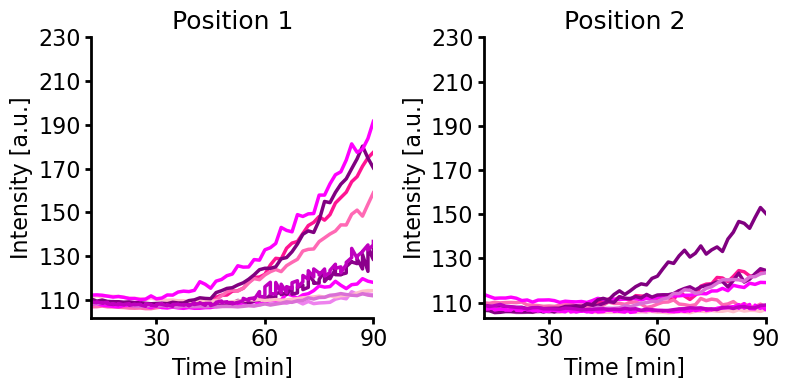

In [66]:
# Background levels (gray scale)
plt.style.use('default') #('dark_background') 

fig = plt.figure(figsize=[8,4])

plt.subplot(121)
th = 120
cells = [0, 10, 20, 30, 40, 50, 60, 110, 120, 2]
colors = ['deeppink', 'hotpink', 'violet', 'magenta', 'darkmagenta', 'pink', 'orchid', 'purple', 'fuchsia', 'm']

# Plot some tracks 
for ind,i in enumerate(cells):
    # Intensity values of Mesp tracks
    intensities = tracks1.spots_features['Mean2'][i]
    
    # Frames where the individual cells' tracks are
    frames = tracks1.spots_features['Frames'][i]
    
    # Plot according to high or low levels of mesp
    if max(intensities)>= th:
        plt.plot(frames, intensities, linewidth=2.5, color=colors[ind])
    else:
        plt.plot(frames, intensities, linewidth=2.5, color=colors[ind])

plt.title('Position 1', fontsize=18)
plt.xlabel('Time [min]',fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr/60)), fontsize=16)
plt.xlim([8,60])
plt.yticks([110,130,150,170,190, 210, 230],fontsize=16)
plt.ylabel('Intensity [a.u.]',fontsize=16)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
th = 120
cells = [0,50,100,150, 120,54,57,11,15,29]

# Plot some tracks 
for ind,i in enumerate(cells):
    # Intensity values of Mesp tracks
    intensities = tracks2.spots_features['Mean2'][i]
    
    # Frames where the individual cells' tracks are
    frames = tracks2.spots_features['Frames'][i]
    
    # Plot according to high or low levels of mesp
    if max(intensities)>= th:
        plt.plot(frames, intensities, linewidth=2.5, color=colors[ind])
    else:
        plt.plot(frames, intensities, linewidth=2.5, color=colors[ind])

plt.title('Position 2', fontsize=18)
plt.xlabel('Time [min]',fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr/60)), fontsize=16)
plt.xlim([8,60])
plt.yticks([110,130,150,170,190,210,230],fontsize=16)
plt.ylabel('Intensity [a.u.]',fontsize=16)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.tight_layout()
fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/HeidiTracks-1-2.pdf', format='pdf')

## Plotting according to spatial position 

An entire somite was backtracked for two different embryos (Position 1, Position 2). Here we show how these cells rearrange from the somite S-1 all the wat until they form somite S1. 

### Position 1

In [67]:
# Number of total timepoints
n_timepoints = len(tracks1.spots_features['Frames'][0])

# Total number of cells
n_cells = len(tracks1.spots_features['X'])

# Save x,y,z according to timepoints
x_pos = {k: [] for k in range(n_timepoints)}
y_pos = {k: [] for k in range(n_timepoints)}
z_pos = {k: [] for k in range(n_timepoints)}
mean_vals = {k: [] for k in range(n_timepoints)}

max_val = 0
min_val = np.inf

# For each cell
for i in range(n_cells):
    frames = tracks1.spots_features['Frames'][i]
    
    # Find maximum value
    if max(tracks1.spots_features['Mean2'][i])>max_val:
        max_val = max(tracks1.spots_features['Mean2'][i])
    # Find minmimum value
    if min(tracks1.spots_features['Mean2'][i])<min_val:
        min_val = max(tracks1.spots_features['Mean2'][i])
        
    # Save each XYZ position and mean in the correct timepoint
    for j,val in enumerate(frames):
        x_pos[val].append(tracks1.spots_features['X'][i][j])
        y_pos[val].append(tracks1.spots_features['Y'][i][j])
        z_pos[val].append(tracks1.spots_features['Z'][i][j])
        mean_vals[val].append(tracks1.spots_features['Mean2'][i][j])
        
# Normalized mean values
mean_vals_norm = {k: [] for k in range(n_timepoints)}

for i in range(n_timepoints):
    mean_vals_norm[i] = list(mean_vals[i]/max_val)# - min(mean_vals[i]/max_val))

print('Minimum value is : %f'%min_val)
print('Maximum value is : %f'%max_val)

Minimum value is : 113.335329
Maximum value is : 220.561288


## Ratio Analysis

### Merge all the data and calculate the ratios

In [68]:
# How many points to take into account for the average of Area 1 and 2

def ratio_mesp(window, intensities):
    # Compute the areas
    area1 = np.mean(intensities[:window])
    area2 = np.mean(intensities[-window:])

    # Compute the ratio
    ratio = area2 - area1
    
    return ratio

# Compute the ratio: Area 2 / Area 1 
ratio1 = []
ratio2 = []
ratio3 = []

intensities_all = []
frames_all = []

# Join both embryos to analyze them as 1 experiment
for j in position:
    
    intensities_aux = eval('tracks%d.spots_features["Mean2"]'%j)
    frames_aux = eval('tracks%d.spots_features["Frames"]'%j)
    
    for i in range(len(intensities_aux)):

        # Intensity values of Mesp tracks
        intensities = intensities_aux[i][8:]
        frames = frames_aux[i][8:]

        if intensities.size>0:
            ratio1.append(ratio_mesp(5, intensities))
            ratio2.append(ratio_mesp(10, intensities))
            ratio3.append(ratio_mesp(15, intensities))

            intensities_all.append(intensities)
            frames_all.append(frames)
    

### Area 1 and Area 2 plots

These areas are the ones used to calculate the Mesp Fold Change. We define this window where we will get all intensity values from all those traces during those window timepoints and we will perform the average. Then for the Mesp Fold Change we will compare these two areas with their respective average intensities. 

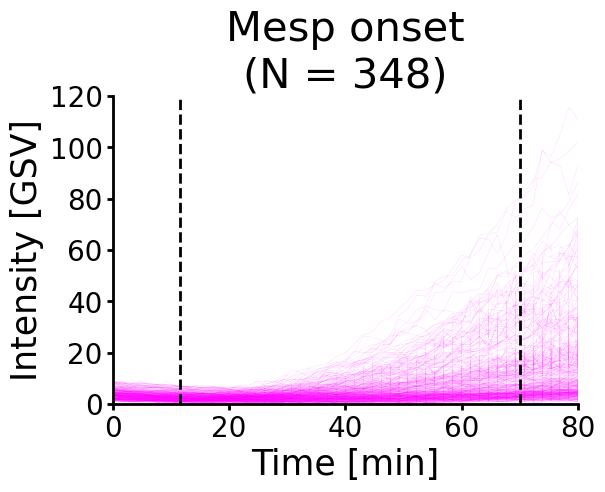

In [69]:
fig = plt.figure(figsize=[6,4])

offset = 8
window = 5


for i in range(len(intensities_all)):
    plt.plot(frames_all[i], intensities_all[i]-105, alpha=0.5, color='magenta', linewidth=0.1)


plt.axvline(window*tr_min+offset, color='black', linestyle='--', linewidth=2)
plt.axvline(n_timepoints - window*tr_min, color='black', linestyle='--', linewidth=2)

plt.xlabel('Time [min]',fontsize=25)
plt.xticks(np.linspace(8,90/tr_min,5), np.linspace(0,80,5, dtype=int), fontsize=20)
plt.xlim([8,60])
plt.yticks(np.arange(0,130,20),fontsize=20)
plt.ylim([0,120])
plt.ylabel('Intensity [GSV]',fontsize=25)
plt.title('Mesp onset\n(N = %d)'%(len(intensities_all)), fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/MespTraces-window.pdf',bbox_inches='tight')

### Distributions of average values of Area 1 and Area 2

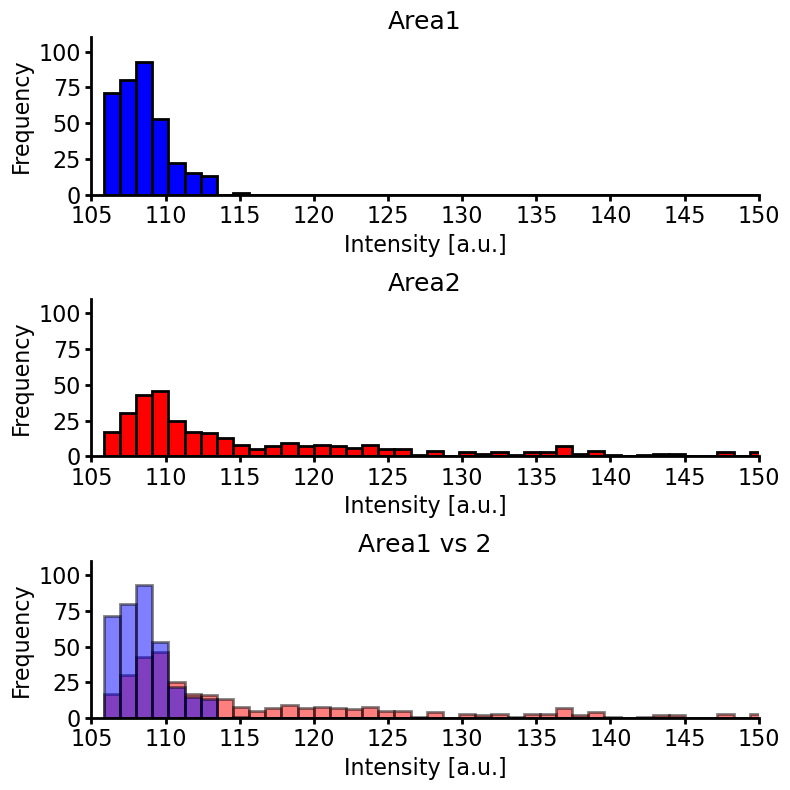

In [70]:
plt.figure(figsize=[8,8])

mean_val1 = []
mean_val2 = []

for i in range(len(intensities_all)):
    mean_val1.append(np.mean(intensities_all[i][:5]))
    mean_val2.append(np.mean(intensities_all[i][-5:]))

# Remove nans
mean_val2 = np.array(mean_val2)
if np.isnan(np.sum(mean_val2)):
    mean_val2 = mean_val2[~np.isnan(mean_val2)]
    
# Remove nans
mean_val1 = np.array(mean_val1)
if np.isnan(np.sum(mean_val1)):
    mean_val1 = mean_val1[~np.isnan(mean_val1)]

bins=np.histogram(np.hstack((mean_val1,mean_val2)), bins='fd')[1] #get the bin edges

plt.subplot(311)
plt.hist(mean_val1, bins, color='blue', edgecolor='black', linewidth=2)
plt.title('Area1', fontsize=18)
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('Intensity [a.u.]',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0,110])
plt.xlim([105,150])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(312)
plt.hist(mean_val2, bins, color='red', edgecolor='black', linewidth=2)
plt.title('Area2', fontsize=18)
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('Intensity [a.u.]',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0,110])
plt.xlim([105,150])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(313)
plt.hist(mean_val2, bins, color='red', edgecolor='black', linewidth=2, alpha=0.5)
plt.hist(mean_val1, bins, color='blue', edgecolor='black', linewidth=2, alpha=0.5)
plt.title('Area1 vs 2', fontsize=18)
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('Intensity [a.u.]',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0,110])
plt.xlim([105,150])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

### Mesp Fold Change

Mesp Fold Change = Area 2 - Area 1

Window = 5 and percentageo of 42


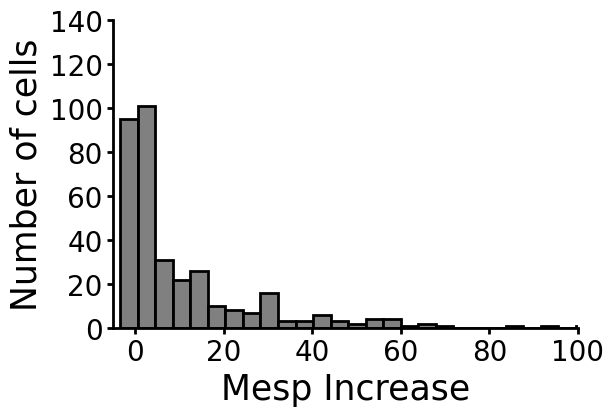

In [71]:
# Distributions

fig = plt.figure(figsize=[6,4])

# Calculate the percentage of Mesp on cells
th = 5
# Remove nans
    
plt.hist(ratio1, edgecolor='black', bins='fd', linewidth=2, color='grey')
plt.xlabel('Mesp Increase', fontsize=25)
plt.ylabel('Number of cells', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-5,100])
plt.ylim([0,140])
percent = len(np.where(np.array(ratio1)>th)[0])/len(ratio1)
print('Window = 5 and percentageo of %d'%(percent*100))
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/MespFoldChange.pdf', bbox_inches='tight')

## Clustering 
### Determine number of clusters with the elbow method

When K increases, the centroids are closer to the clusters centroids.
The improvements will decline, at some point rapidly, creating the elbow shape.
Check this [link](https://pythonprogramminglanguage.com/kmeans-elbow-method/) for more information about this method.

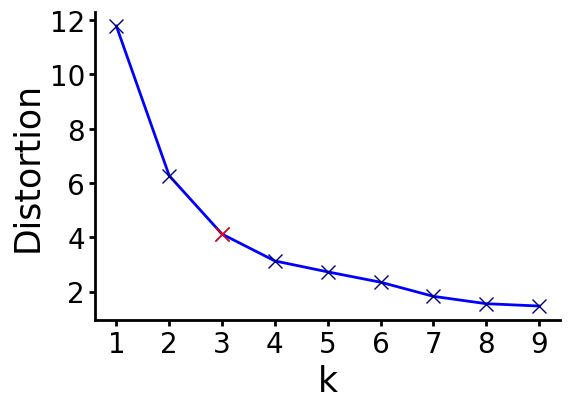

In [72]:
# k means determine k: ELBOW METHOD
window = 5


fig = plt.figure(figsize=[6,4])

    
distortions = []
K = range(1,10)

# Define the data
X = np.array(ratio1).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=100).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-', linewidth=2, markersize=10,  mec='navy')
plt.plot(3, distortions[2], 'bx-', linewidth=6, markersize=10,  mec='red')

plt.xlabel('k', fontsize=25)
plt.ylabel('Distortion', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title('Elbow Method', fontsize=30)
#plt.title('The Elbow Method showing the optimal k', fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()
fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/ElbowMethod.pdf', bbox_inches='tight')

### Silhouette Method

In [73]:
# SILHOUETTE METHOD

from sklearn.metrics import silhouette_samples, silhouette_score


range_n_clusters = [2, 3, 4, 5]


window = 5
    
for n_clusters in range_n_clusters:

    # Define the data
    X = np.array(ratio1).reshape(-1, 1)
    X[np.where(np.isnan(X))] = 0 # In case there is any nan

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=50)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.7567821307772288
For n_clusters = 3 The average silhouette_score is : 0.6983461542559942
For n_clusters = 4 The average silhouette_score is : 0.6918539843280903
For n_clusters = 5 The average silhouette_score is : 0.6958368069561035


### K-Means Classification

Using a cluster size of 3, we will classify the distribution that we obtained for the Mesp onset fold change. 

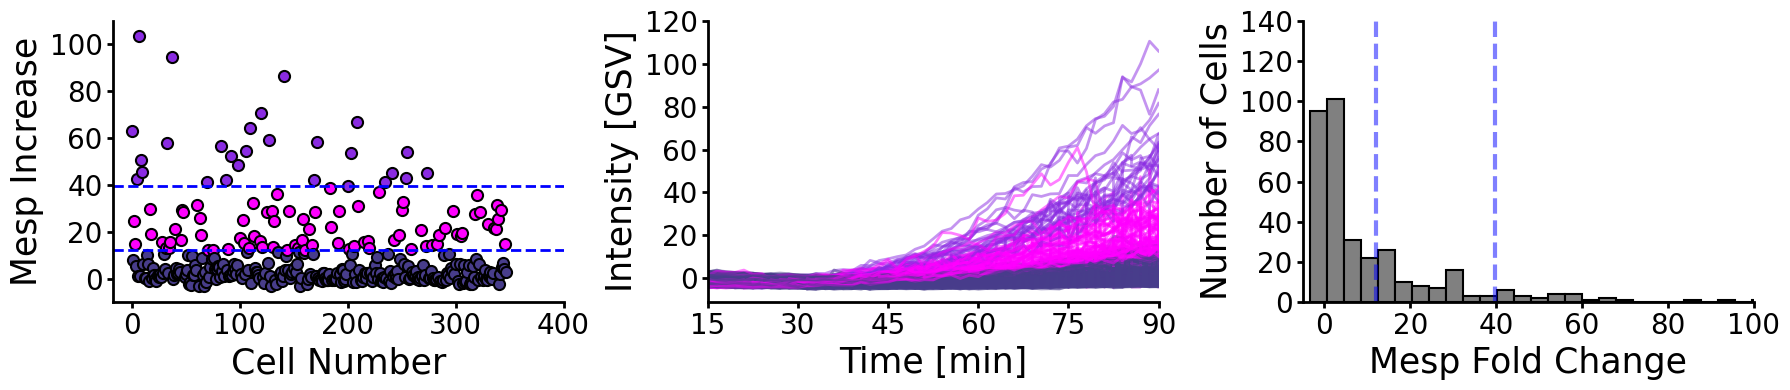

In [74]:
# Distributions

fig = plt.figure(figsize=[18,4])

plt.subplot(131)
# Calculate the percentage of Mesp on cells

# Remove nans
ratio1_ = np.array(ratio1)
inds = np.where(np.isnan(ratio1_))[0]

if np.isnan(np.sum(ratio1_)):
    ratio1_ = ratio1_[~np.isnan(ratio1_)]
    
#color = ['navy', 'deepskyblue', 'royalblue', 'aqua']
color = ['darkslateblue', 'magenta', 'blueviolet']#'mediumorchid']

# Use the same seed to avoid changing clusters 
# Define the data
X = np.array(ratio1_).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred1 = KMeans(n_clusters=3, n_init=200, random_state=1).fit_predict(X)

group1 = np.where(y_pred1==1)[0]
group2 = np.where(y_pred1==2)[0]
group3 = np.where(y_pred1==0)[0]

val1 = np.min(ratio1_[group1])
val2 = np.min(ratio1_[group2])

th1 = np.mean(ratio1_<= val1)*100
th2 = np.mean(ratio1_<= val2)*100

for i in range(len(X)):
    plt.plot(i, X[i], 'o', markersize=8, markerfacecolor=color[y_pred1[i]], markeredgewidth=1.5, markeredgecolor='black')

plt.axhline(val1, color='blue', linewidth=2, linestyle='--')
plt.axhline(val2, color='blue', linewidth=2, linestyle='--')

plt.xlabel('Cell Number', fontsize=25)
plt.ylabel('Mesp Increase', fontsize=25)
plt.ylim([-10,110])
plt.yticks(fontsize=20)
plt.xticks(np.arange(0,500,100),fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(132)
count = 0
for i in range(len(intensities_all)):   
    if all(i != inds):
        plt.plot(frames_all[i], intensities_all[i]-110, c=color[y_pred1[count]],alpha=0.5, linewidth=2)    
        count +=1 
plt.xlabel('Time [min]',fontsize=25)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr/60)), fontsize=20)
plt.xlim([10,60])
plt.yticks(np.arange(0,130,20),fontsize=20)
plt.ylabel('Intensity [GSV]',fontsize=25)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(133)

plt.hist(ratio1_, color='grey', edgecolor='black', bins='fd', linewidth=1.5)
plt.axvline(val1, color='blue', linewidth=3, alpha=0.5, linestyle='dashed')
plt.axvline(val2, color='blue', linewidth=3, alpha=0.5, linestyle='dashed')

plt.xlabel('Mesp Fold Change', fontsize=25)
plt.ylabel('Number of Cells', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-5,100])
plt.ylim([0,140])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/KMeans-Results.pdf', bbox_inches='tight')

In [75]:
print('Percentage of cells in group 1: %.2f'%(len(group1)*100/sum([len(group1),len(group2),len(group3)])))
print('Percentage of cells in group 2: %.2f'%(len(group2)*100/sum([len(group1),len(group2),len(group3)])))
print('Percentage of cells in group 3: %.2f'%(len(group3)*100/sum([len(group1),len(group2),len(group3)])))

Percentage of cells in group 1: 22.13
Percentage of cells in group 2: 7.76
Percentage of cells in group 3: 70.11


In [76]:
print('Percentage of cells with Mesp ON: %.2f'%(7.88+20.94))

Percentage of cells with Mesp ON: 28.82


### Fold change vs traces

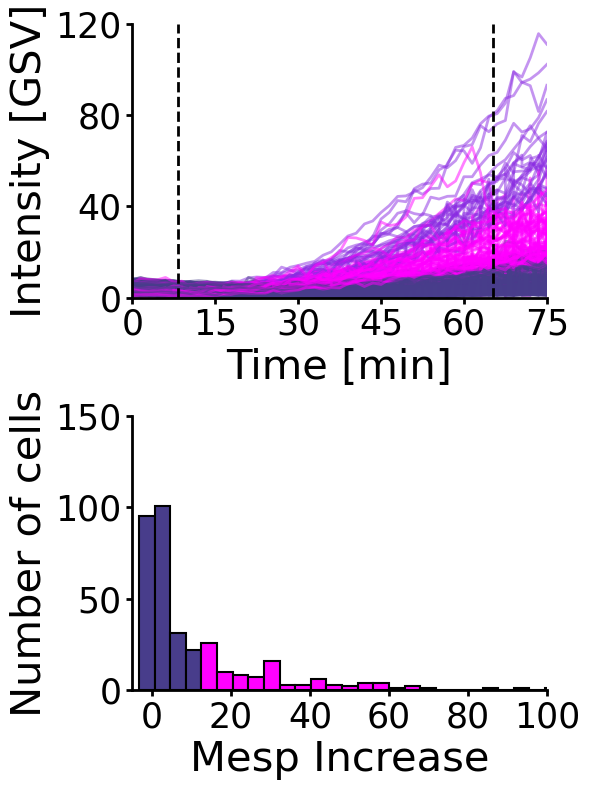

In [77]:
# Distributions

fig = plt.figure(figsize=[6,8])

plt.subplot(211)
count = 0 
for i in range(len(intensities_all)):   
    if all(i != inds):
        plt.plot(frames_all[i], intensities_all[i]-105, c=color[y_pred1[count]],alpha=0.5, linewidth=2)    
        count +=1 

plt.axvline(window*tr_min+offset, color='black', linestyle='--', linewidth=2)
plt.axvline(n_timepoints - window*tr_min, color='black', linestyle='--', linewidth=2)

plt.xlabel('Time [min]',fontsize=30)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr/60)-15), fontsize=25)
plt.xlim([10,60])
plt.ylim([0,120])
#plt.yticks([110,130,150,170,190,210,230],fontsize=25)
plt.yticks(np.arange(0,160,40), fontsize=25)
plt.ylabel('Intensity [GSV]',fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(212)

N, bins, patches = plt.hist(ratio1_, edgecolor='black', linewidth=1.5, bins='fd')
#plt.hist(ratio1_, edgecolor='black', color='gray', bins='fd', linewidth=2)
ind1 = np.argmin((val1-bins)**2)
ind2 = np.argmin((val2-bins)**2)

for i in range(0,ind2):
    patches[i].set_facecolor(color[0])
for i in range(ind2,ind1):    
    patches[i].set_facecolor(color[2])
for i in range(ind1, len(patches)):
    patches[i].set_facecolor(color[1])
    

plt.xlabel('Mesp Increase', fontsize=30)
plt.ylabel('Number of cells', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim([-5,100])
plt.ylim([0,150])
plt.yticks(np.arange(0,180,50))
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/ClusteredKMeans-FoldChangeMesp.pdf', format='pdf', bbox_inches='tight')

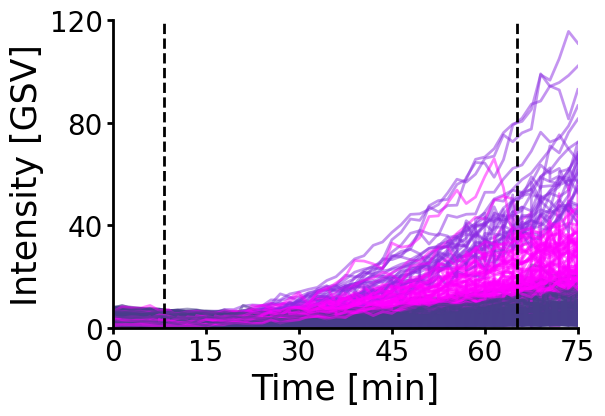

In [78]:
# Distributions

fig = plt.figure(figsize=[6,4])

count = 0 
for i in range(len(intensities_all)):   
    if all(i != inds):
        plt.plot(frames_all[i], intensities_all[i]-105, c=color[y_pred1[count]],alpha=0.5, linewidth=2)    
        count +=1 

plt.axvline(window*tr_min+offset, color='black', linestyle='--', linewidth=2)
plt.axvline(n_timepoints - window*tr_min, color='black', linestyle='--', linewidth=2)

plt.xlabel('Time [min]',fontsize=25)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr/60)-15), fontsize=20)
plt.xlim([10,60])
plt.ylim([0,120])
#plt.yticks([110,130,150,170,190,210,230],fontsize=25)
plt.yticks(np.arange(0,160,40), fontsize=20)
plt.ylabel('Intensity [GSV]',fontsize=25)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/ClusteredKMeans-MespIncrease-Traces.pdf', format='pdf', bbox_inches='tight')

### In cells with high Mesp values, when is this happening?

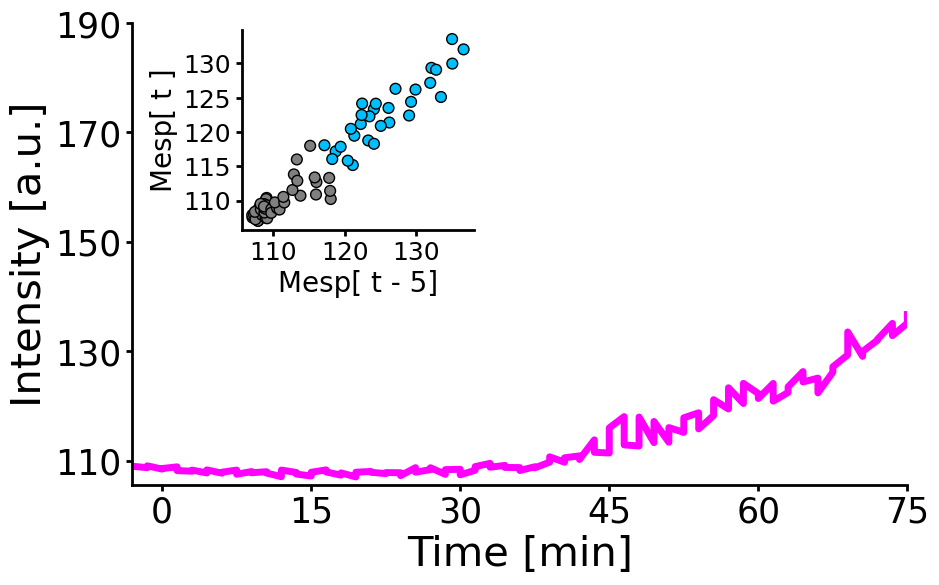

In [79]:
fig = plt.figure(figsize=(10, 6),facecolor='white')
ax = fig.add_subplot(111)

i = np.where(y_pred1==1)[0][0]

window = 5

X = np.zeros((len(intensities_all[i][window:]),2))
X[:,0] = intensities_all[i][window:]
X[:,1] = intensities_all[i][:-window]
y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)



ind_cut = np.where(y_pred[5:]==y_pred[-1])[0]+5
plt.plot(frames_all[i], intensities_all[i], color='magenta', linewidth=5)
plt.axvline(ind_cut[0], color='blue', linewidth=4, linestyle='dashed')

plt.xlabel('Time [min]',fontsize=30)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round((locs-10)*tr/60)), fontsize=25)
plt.xlim([8,60])
plt.yticks([110,130,150,170,190],fontsize=25)
plt.ylabel('Intensity [a.u.]',fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

# this is an inset axes over the main axes
inset_axes_ = inset_axes(ax, 
                    width="30%", # width = 30% of parent_bbox
                    height=2, # height : 1 inch
                    bbox_to_anchor=(-0.55, 0, 1, 1),
                    bbox_transform=ax.transAxes)

cmap_m = matplotlib.colors.ListedColormap(['grey', 'deepskyblue'])
plt.scatter(X[:,0], X[:,1], c=y_pred,alpha=1,cmap=cmap_m,s=60,edgecolors='k')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Mesp[ t - %d]'%window, fontsize=20)
plt.ylabel('Mesp[ t ]', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/ExampleCell-MespOnset.pdf', format='pdf', bbox_inches='tight')

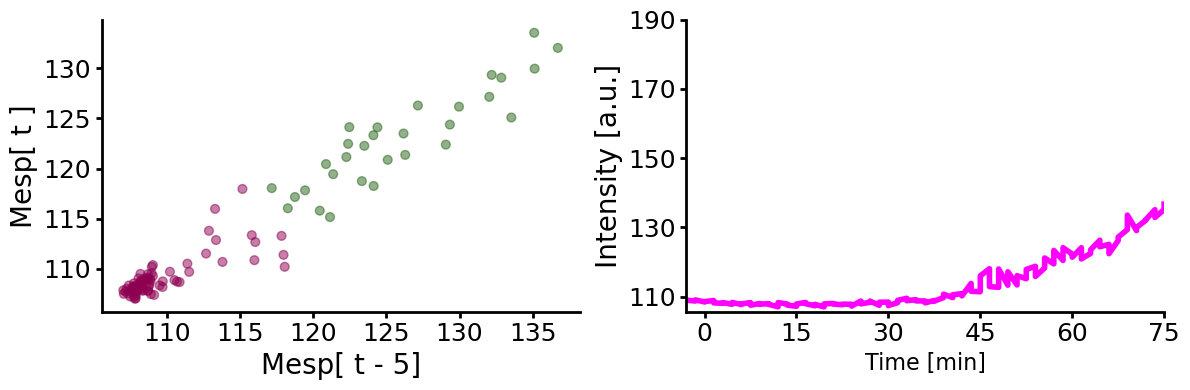

In [80]:
i = np.where(y_pred1==1)[0][0]

window = 5

X = np.zeros((len(intensities_all[i][window:]),2))
X[:,0] = intensities_all[i][window:]
X[:,1] = intensities_all[i][:-window]
y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

plt.figure(figsize=[12,4])
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y_pred,alpha=0.5,cmap='PiYG',s=40)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Mesp[ t - %d]'%window, fontsize=20)
plt.ylabel('Mesp[ t ]', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
ind_cut = np.where(y_pred[5:]==y_pred[-1])[0]+5
plt.plot(frames_all[i], intensities_all[i], color='magenta', linewidth=4)
plt.axvline(ind_cut[0], color='black', linewidth=2, linestyle='dashed')

plt.xlabel('Time [min]',fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round((locs-10)*tr/60)), fontsize=18)
plt.xlim([8,60])
plt.yticks([110,130,150,170,190],fontsize=18)
plt.ylabel('Intensity [a.u.]',fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/ExampleCell-MespOnset.pdf', format='pdf', bbox_inches='tight')